<a href="https://colab.research.google.com/github/orcacaor/aiffel_quest/blob/main/20251226_comp_clf_rubric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# 마감시간이 다 돼서 우선 평가용 코드를 제출합니다
# 코드가 코랩, vs코드에 너무 많이 흩어져있어서 주섬주섬 모았습니다

# 코드 및 주석은 LLM 에게 지시해서 생성된 것이니 읽으실 필요는 없고
# 제 의도 및 설명을 #ㅡㅡㅡㅡㅡㅡ << 이렇게 생긴 주석에 달아두었습니다

#ㅡㅡㅡㅡㅡㅡ 의도의도의도

In [37]:
# 요구사항

# - 데이터 이해 및 탐색: Class의 균형과 데이터의 분포와 특성을 시각화를 통해서 파악했는가? (완료)
# - 모델 선택 및 비교: 3개 이상의 모델을 학습시키고 성능을 비교했는가? (완료)
# - 레이블 불균형을 처리하기 위한 기법을 시도했는가? (완료)
# - 여러 모델을 앙상블을 통해 결합하여 성능을 비교했는가? (완료)
# - Ridge/Lasso 등의 규제 추가, 트리 기반 모델의 깊이/학습률 등 하이퍼파라미터를 조정하여 성능 향상을 시도했는가? (완료)

In [60]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 클래스 불균형 확인

In [41]:
train['Class'].value_counts()

,count
Class,
0,170523
1,360


In [ ]:
train['Class'].value_counts(normalize=True)

In [ ]:
train.duplicated().sum()

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 데이터 확인

In [ ]:
train_check = pd.concat([train.dtypes, train.nunique(), train.isnull().sum(), (train.isnull().sum() / len(train)) * 100], axis=1)
train_check.columns = ['dtype', 'nunique', 'null', 'null_ratio']

train_check

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 행 숫자와 id숫자 같음 = 행 구분 외의 기능 없음. 삭제

In [ ]:
train = train.drop(columns=['id']).copy()
test = test.drop(columns=['id']).copy()

display(train.head())
display(test.head())

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 피처 엔지니어링
#ㅡㅡㅡㅡㅡㅡ Time과 Amount의 값이
#ㅡㅡㅡㅡㅡㅡ V피처들과 크기가 매우 달라서 스케일링
#ㅡㅡㅡㅡㅡㅡ 이상치에 강한 로버스트 스케일러 선택

In [42]:
from sklearn.preprocessing import RobustScaler

# Time, Amount 스케일링 -> 새로운 컬럼 생성
rs = RobustScaler()
cols = ['Time', 'Amount']

# 스케일러 학습 및 변환 (Train은 fit_transform, Test는 transform)
# 결과는 numpy array 형태([행, 2])로 반환됩니다. (0번 인덱스: Time, 1번 인덱스: Amount)
train_scaled = rs.fit_transform(train[cols])
test_scaled = rs.transform(test[cols])

# 새로운 컬럼에 할당
train['scaled_time'] = train_scaled[:, 0]
train['scaled_amount'] = train_scaled[:, 1]

test['scaled_time'] = test_scaled[:, 0]
test['scaled_amount'] = test_scaled[:, 1]


# 원본 Time, Amount 컬럼 삭제
train = train.drop(cols, axis=1)
test = test.drop(cols, axis=1)

# 결과 확인
print("변경된 Train 컬럼 목록:", train.columns.tolist())
display(train.head())

변경된 Train 컬럼 목록: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'scaled_time', 'scaled_amount']


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_time,scaled_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.624788,1.792953
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.624788,-0.269512
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.624761,5.008001
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.624761,1.426305
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.624734,0.675182


In [43]:
test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_time,scaled_amount
0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,-2.277774,0.310404,...,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,1.593883,1.447080
1,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,0.529802,0.776728,...,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,1.593883,0.394582
2,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,-0.648266,0.376802,...,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,1.593883,-0.185289
3,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,-0.041604,-0.694289,...,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,1.593883,0.534812
4,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,-0.634128,0.975375,...,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,1.593883,1.376755


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 지금 하려는 것
#ㅡㅡㅡㅡㅡㅡ Class 1 비율이 약 0.2%밖에 없어서 V피처와의 관계가 제대로 드러나지 않는 상태
#ㅡㅡㅡㅡㅡㅡ 모든 사기데이터(Class 1)을 모으고 그 와 동일한 정상 데이터를 동일한 비율로 무작위 추출
#ㅡㅡㅡㅡㅡㅡ 이렇게 만든 50:50 서브셋은 V피처와 사기데이터 관계가 뚜렷히 드러날 것을 기대

In [44]:
# 1. Class별로 데이터를 나눕니다.
fraud_df = train[train['Class'] == 1]
normal_df = train[train['Class'] == 0]

print(f"사기 거래 개수: {len(fraud_df)}")
print(f"정상 거래 개수: {len(normal_df)}")


# 2. Class가 0인 것을 Class가 1인 개수만큼 무작위 샘플링
# random_state=42는 실행할 때마다 같은 결과가 나오도록 고정하는 시드값입니다.
normal_sampled = normal_df.sample(n=len(fraud_df), random_state=42)


# 3. 데이터 합치기 및 섞기 (Shuffle)
# 두 데이터프레임을 합칩니다.
sub_train = pd.concat([fraud_df, normal_sampled], axis=0)

# 데이터를 무작위로 섞습니다.
# frac=1은 전체 데이터를 가져오되 순서를 섞는다는 의미입니다.
sub_train = sub_train.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print("-" * 30)
print("서브 데이터셋(sub_train) 크기:", sub_train.shape)
print("서브 데이터셋 클래스 분포:\n", sub_train['Class'].value_counts())
display(sub_train.head())

사기 거래 개수: 360
정상 거래 개수: 170523
------------------------------
서브 데이터셋(sub_train) 크기: (720, 31)
서브 데이터셋 클래스 분포:
 Class
1    360
0    360
Name: count, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_time,scaled_amount
0,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,-1.593249,-8.993811,...,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,1,1.115157,1.152583
1,-5.100256,3.633442,-3.843919,0.183208,-1.183997,1.602139,-3.005953,-8.645038,1.285458,-3.717481,...,-2.797150,1.090707,-0.159260,0.532156,-0.497126,0.943622,0.553581,1,0.822820,3.359489
2,-17.467710,10.114816,-24.202142,11.805469,-10.198046,-2.579938,-17.656788,2.256902,-6.242149,-12.830657,...,0.940830,1.296817,-1.055104,0.111792,0.679695,2.093541,-1.425491,1,-1.052171,-0.293234
3,-2.326922,-3.348439,-3.513408,3.175060,-2.815137,-0.203363,-0.892144,0.333226,-0.802005,-4.350685,...,-0.695902,-1.478490,-0.061553,0.236155,0.531911,0.302324,0.536375,1,-0.047186,19.198063
4,1.284143,0.462738,-0.371277,0.825644,0.464456,-0.466731,0.459673,-0.186236,-0.549594,0.204381,...,0.084371,-0.246710,-0.325573,0.927623,-0.272459,-0.009998,-0.005489,0,0.312307,-0.294778


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 50:50 서브셋의 상관계수 시각화
#ㅡㅡㅡㅡㅡㅡ 결과 스크롤 내리면
#ㅡㅡㅡㅡㅡㅡ 1. 원본 히트맵
#ㅡㅡㅡㅡㅡㅡ 2. 서브셋 히트맵
#ㅡㅡㅡㅡㅡㅡ 3. Class 상관계수 그래프

### 1. 원본 데이터셋(불균형) 상관관계 히트맵 ###


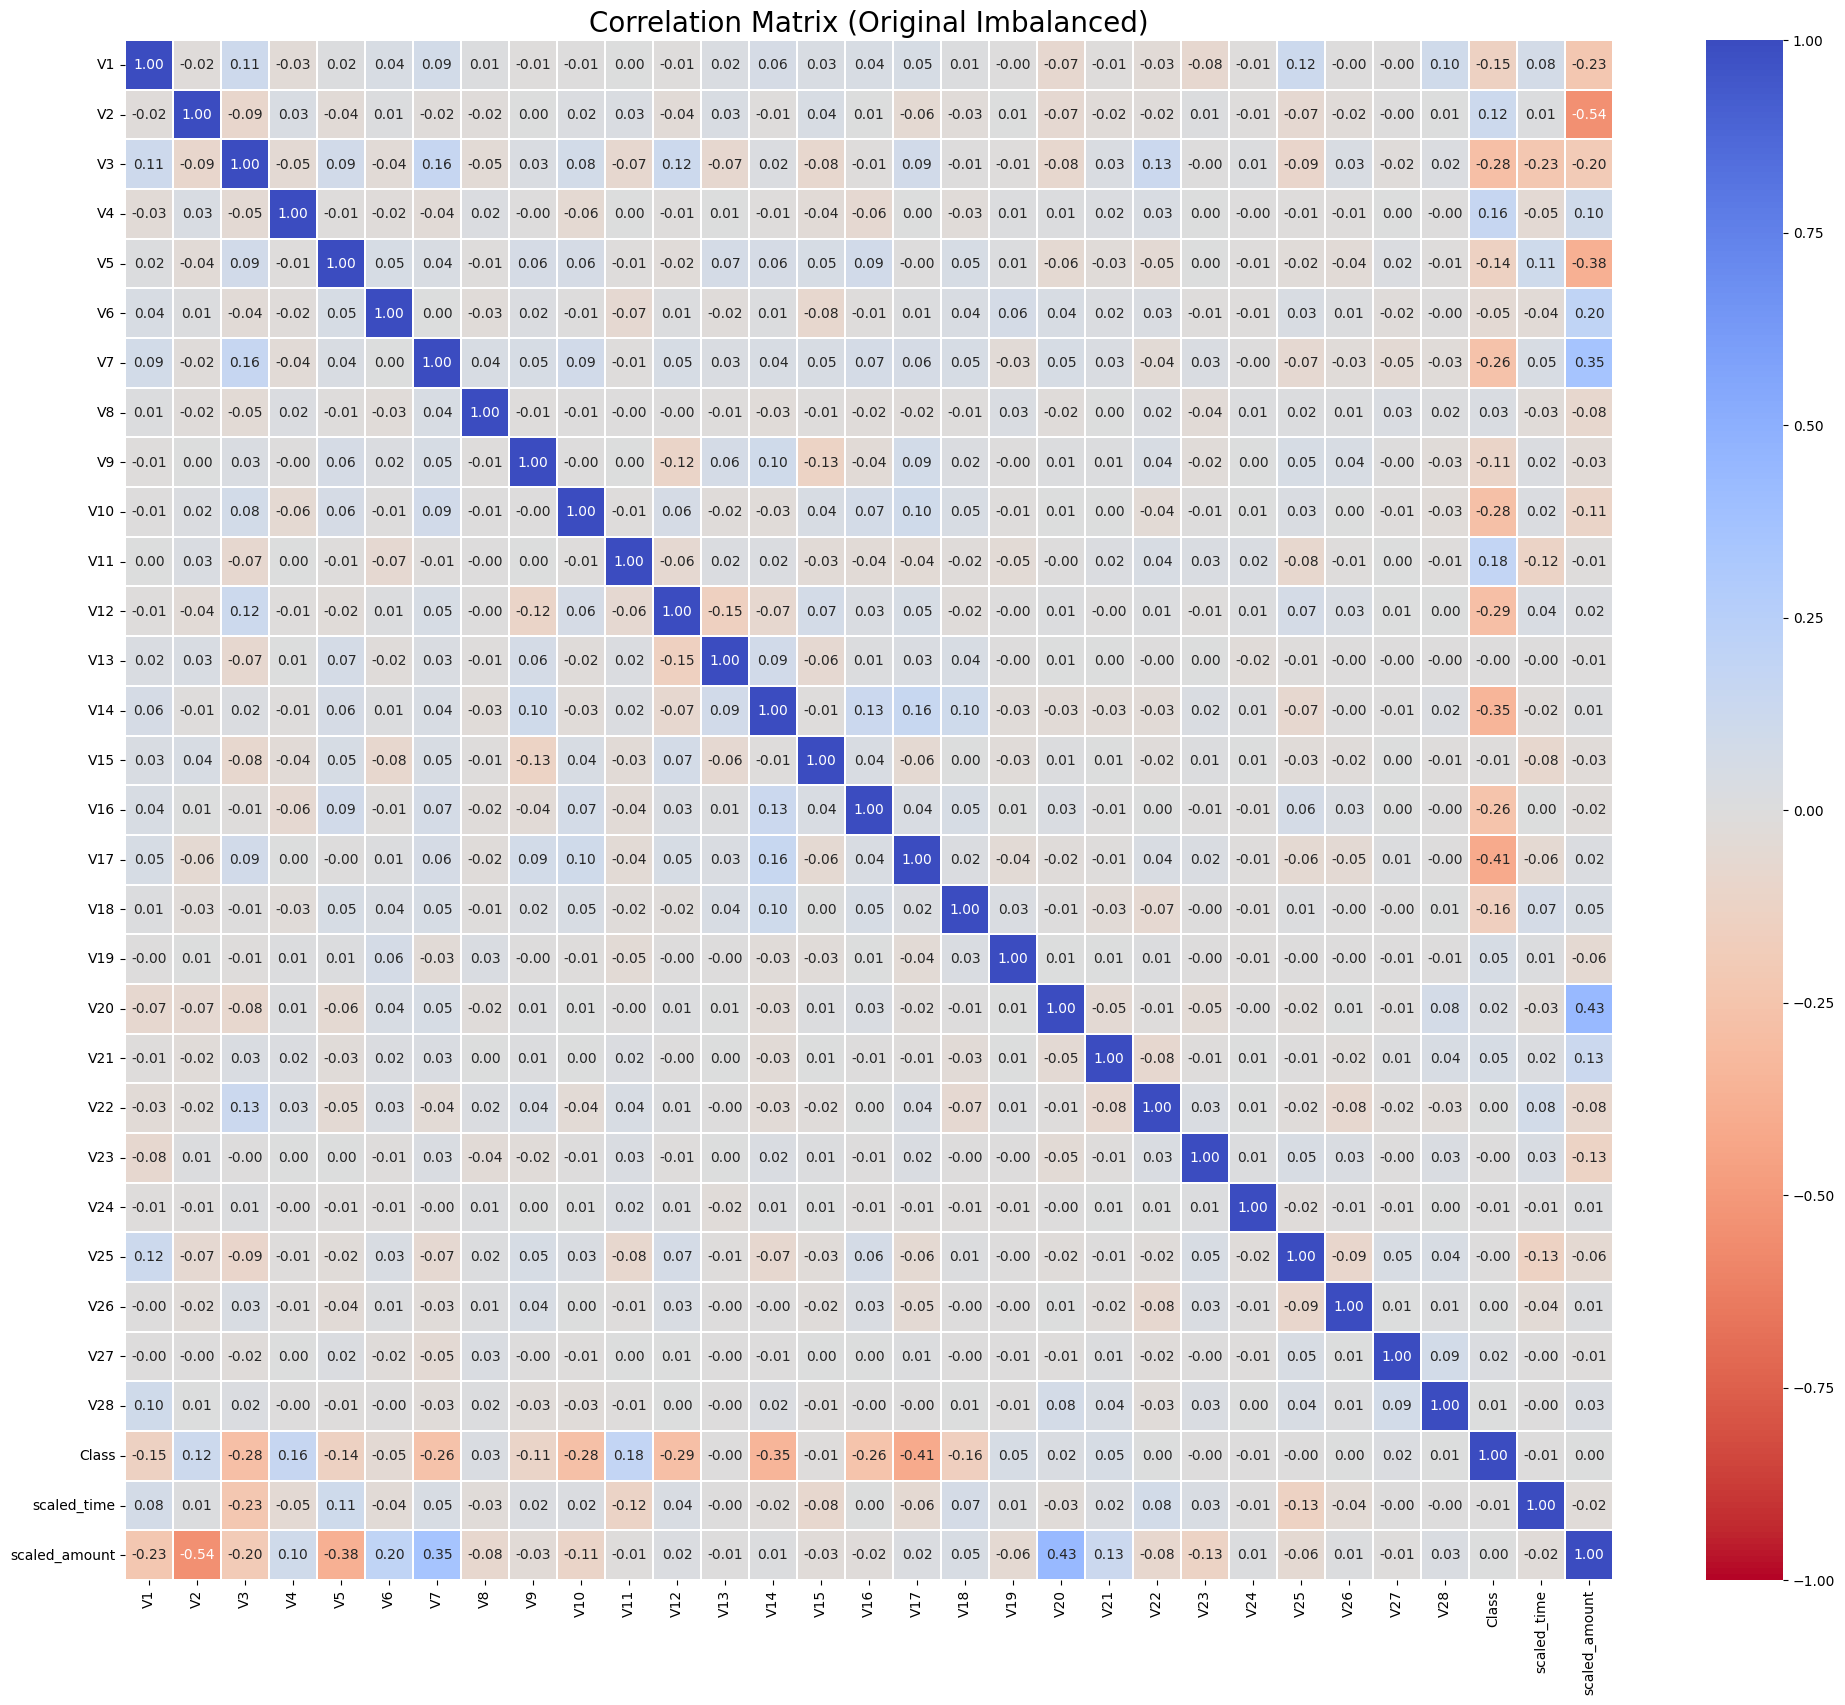


### 2. 서브 데이터셋(균형) 상관관계 히트맵 ###


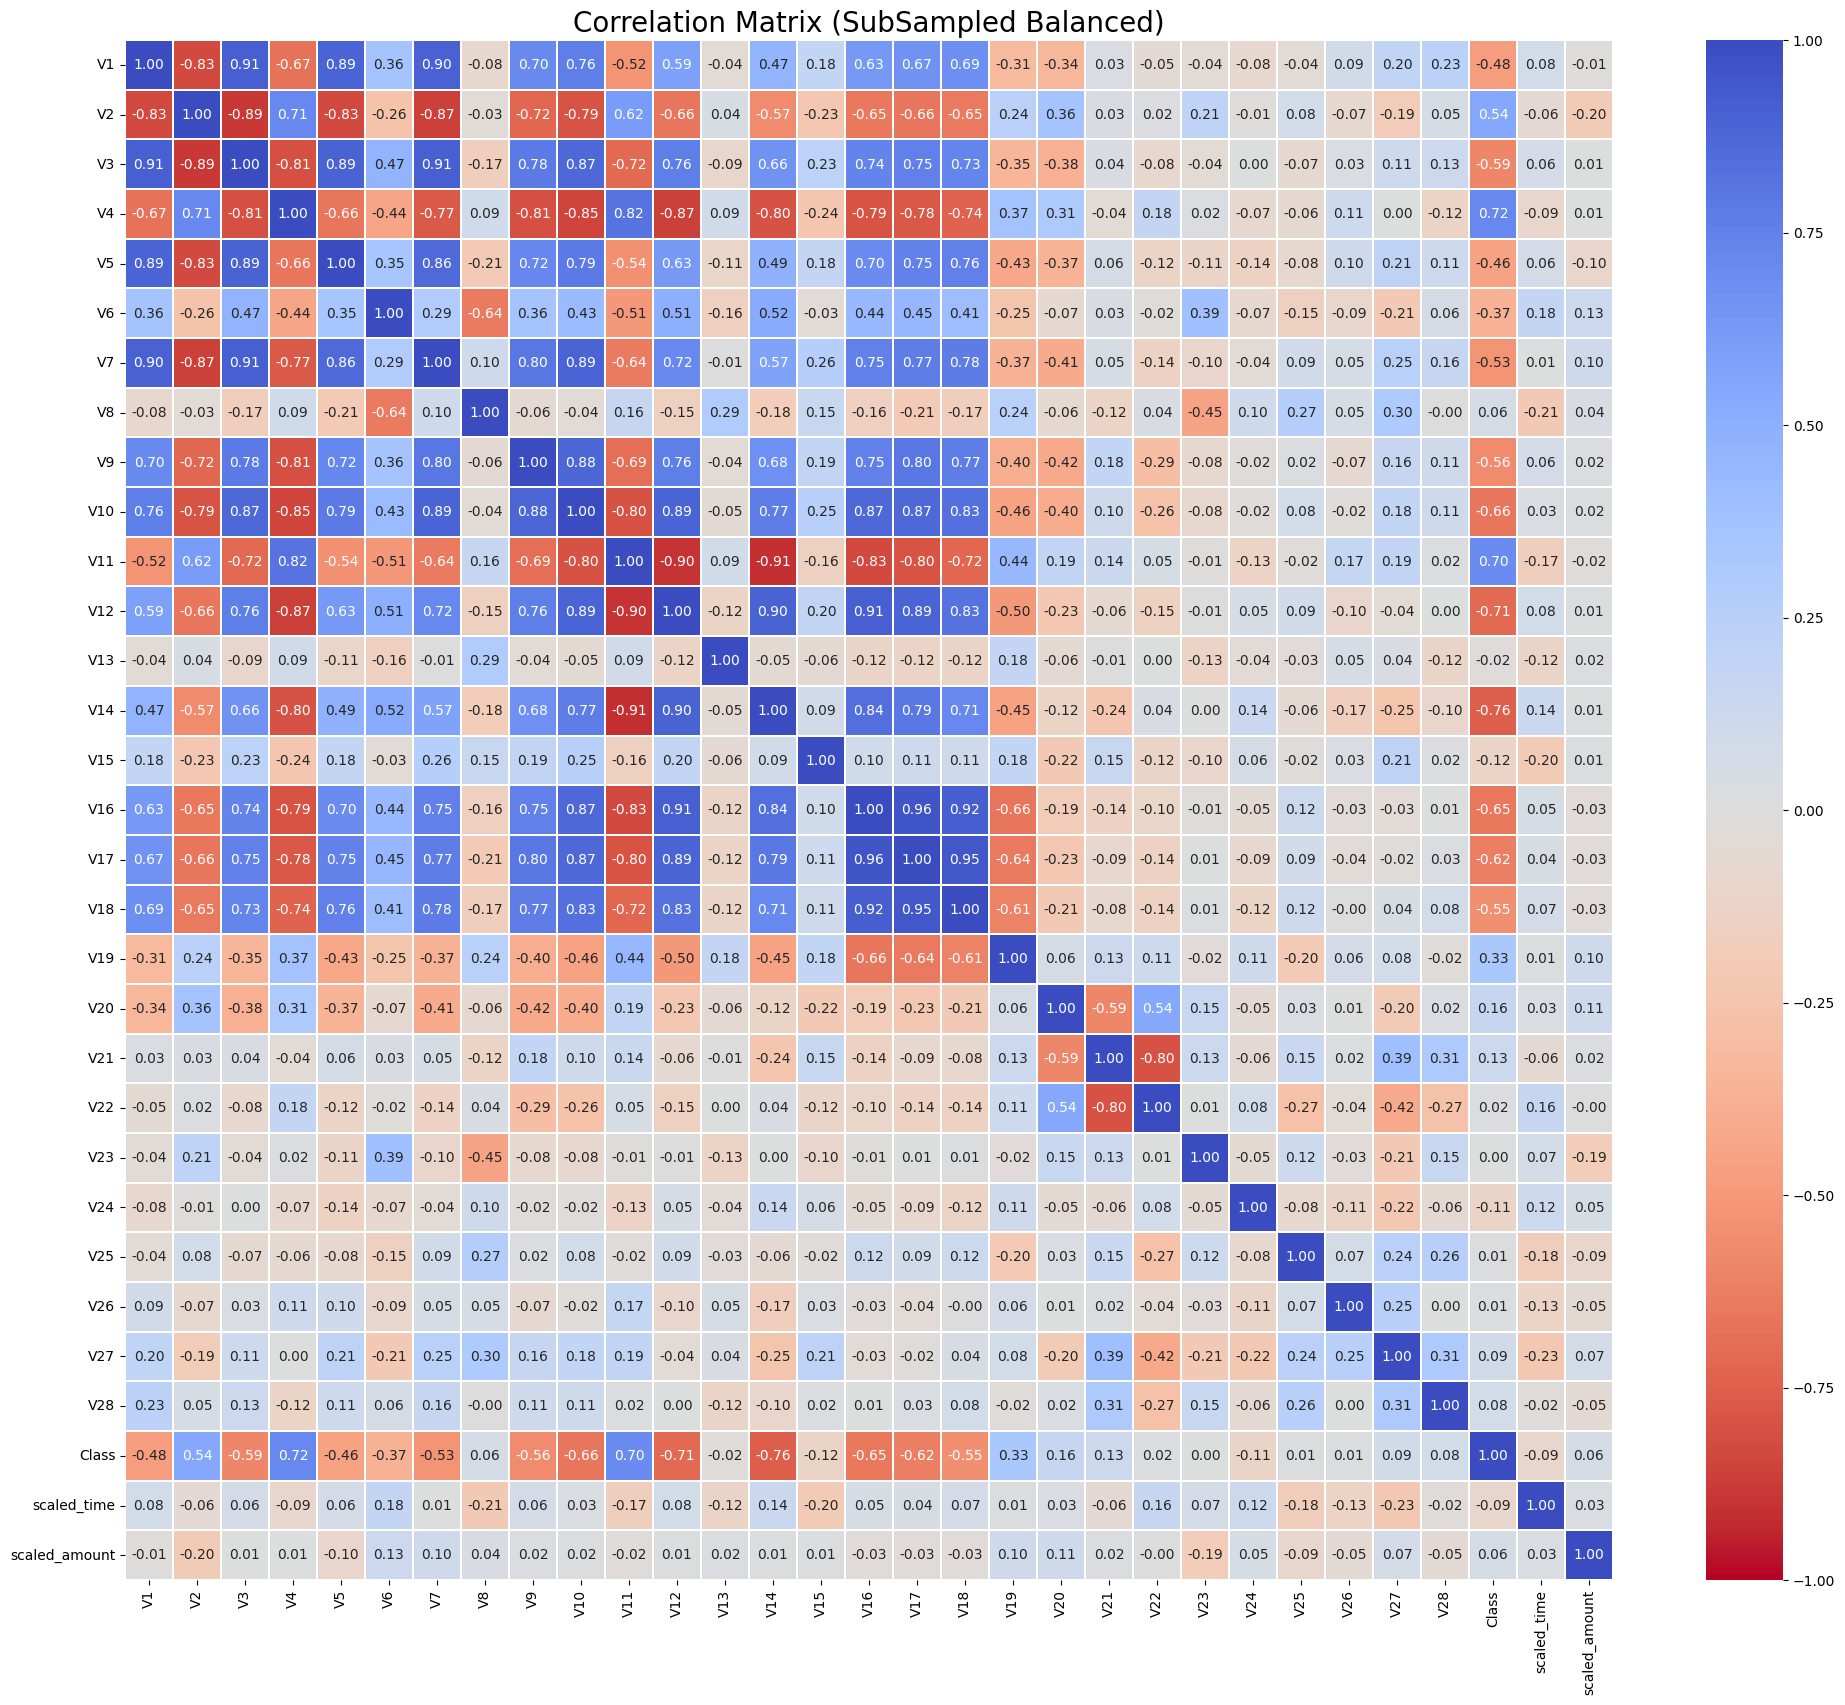


### 3. 'Class'와의 상관관계 분석 (서브셋 기준) ###


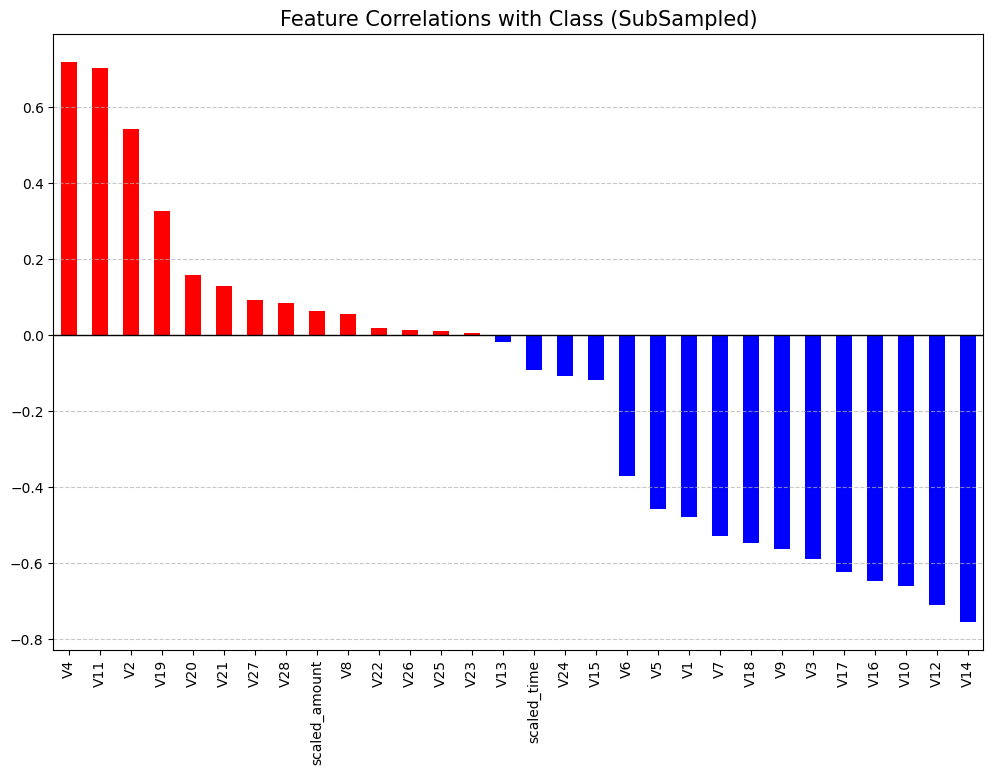


[양의 상관관계 Top 5] (Class가 1일 때 값이 높아지는 경향)
V4     0.717761
V11    0.703017
V2     0.541651
V19    0.326907
V20    0.157281
Name: Class, dtype: float64

[음의 상관관계 Top 5] (Class가 1일 때 값이 낮아지는 경향)
V17   -0.623199
V16   -0.648846
V10   -0.660470
V12   -0.711899
V14   -0.756061
Name: Class, dtype: float64


In [45]:



# 1. 상관관계 매트릭스 계산

corr_original = train.corr()
corr_sub = sub_train.corr()


# 2. 히트맵 시각화 함수 정의

def plot_heatmap(corr_matrix, title):
    # 캔버스 크기 설정
    plt.figure(figsize=(24, 20))

    # 히트맵 그리기
    # cmap='coolwarm_r': 파란색(음) ~ 빨간색(양) ( _r은 reverse)
    # vmin=-1, vmax=1: 상관관계 범위 고정
    # annot=True: 칸 안에 수치 표시
    # fmt='.2f': 소수점 2자리까지 표시
    sns.heatmap(corr_matrix, cmap='coolwarm_r', annot=True, fmt='.2f',
                linewidths=0.2, vmin=-1, vmax=1)

    plt.title(title, fontsize=20)
    plt.show()

# 1) 원본 데이터셋 히트맵
print("### 1. 원본 데이터셋(불균형) 상관관계 히트맵 ###")
plot_heatmap(corr_original, "Correlation Matrix (Original Imbalanced)")

# 2) 서브셋 히트맵
print("\n### 2. 서브 데이터셋(균형) 상관관계 히트맵 ###")
# 이 히트맵이 사기 탐지에 실질적으로 중요한 피처를 보여줍니다.
plot_heatmap(corr_sub, "Correlation Matrix (SubSampled Balanced)")


# 3. 상관관계 수치 정렬 및 상위/하위 피처 확인

print("\n### 3. 'Class'와의 상관관계 분석 (서브셋 기준) ###")

# Class 컬럼과의 상관계수만 추출 (Class 자신은 1이므로 제외)
corr_with_class = corr_sub['Class'].drop('Class')

# 정렬
sorted_corr = corr_with_class.sort_values(ascending=False)

# 시각화 (막대 그래프로 한눈에 보기)
plt.figure(figsize=(12, 8))
colors = ['red' if x > 0 else 'blue' for x in sorted_corr.values]
sorted_corr.plot(kind='bar', color=colors)
plt.title('Feature Correlations with Class (SubSampled)', fontsize=15)
plt.axhline(0, color='black', linewidth=1) # 0 기준선
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 텍스트로 상위/하위 출력
print("\n[양의 상관관계 Top 5] (Class가 1일 때 값이 높아지는 경향)")
print(sorted_corr.head(5))

print("\n[음의 상관관계 Top 5] (Class가 1일 때 값이 낮아지는 경향)")
print(sorted_corr.tail(5))

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 크기로 상관계수 Top10 확인

### 'Class'와의 상관관계 절댓값 Top 10 ###


,Correlation,Abs_Correlation
V14,-0.756061,0.756061
V4,0.717761,0.717761
V12,-0.711899,0.711899
V11,0.703017,0.703017
V10,-0.660470,0.660470
V16,-0.648846,0.648846
V17,-0.623199,0.623199
V3,-0.589965,0.589965
V9,-0.564069,0.564069
V18,-0.548270,0.548270


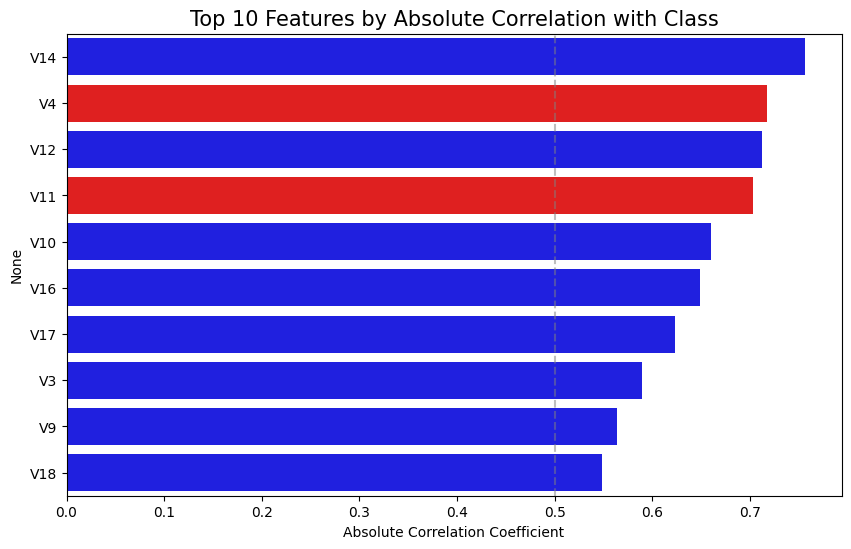

In [46]:

# 1. 서브 데이터셋(sub_train) 기준 상관관계 계산
corr_matrix = sub_train.corr()

# 2. 'Class' 컬럼과의 상관계수만 추출 (Class 자신은 제외)
corr_with_class = corr_matrix['Class'].drop('Class')

# 3. 데이터프레임으로 변환
top10_df = pd.DataFrame(corr_with_class)
top10_df.columns = ['Correlation'] # 컬럼명 설정

# 4. 절댓값(Abs) 컬럼 추가
top10_df['Abs_Correlation'] = top10_df['Correlation'].abs()

# 5. 절댓값 기준으로 내림차순 정렬 후 Top 10 추출
top10_df = top10_df.sort_values(by='Abs_Correlation', ascending=False).head(10)

# ---------------------------------------------------------
# 결과 출력
# ---------------------------------------------------------
print("### 'Class'와의 상관관계 절댓값 Top 10 ###")
display(top10_df)

# ---------------------------------------------------------
# 시각화 (바 차트)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# 색상: 양의 상관관계는 빨강, 음의 상관관계는 파랑
colors = ['red' if x > 0 else 'blue' for x in top10_df['Correlation']]

sns.barplot(x=top10_df['Abs_Correlation'], y=top10_df.index, palette=colors)

plt.title('Top 10 Features by Absolute Correlation with Class', fontsize=15)
plt.xlabel('Absolute Correlation Coefficient')
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5) # 0.5 기준선
plt.show()

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 상위 5개를 뽑아서 확인
#ㅡㅡㅡㅡㅡㅡ 박스플롯으로 시각화
#ㅡㅡㅡㅡㅡㅡ 특히 Class 1 경우의 특징 관찰할 생각

✅ 분석된 Top 5 피처 목록: ['V14', 'V4', 'V12', 'V11', 'V10']


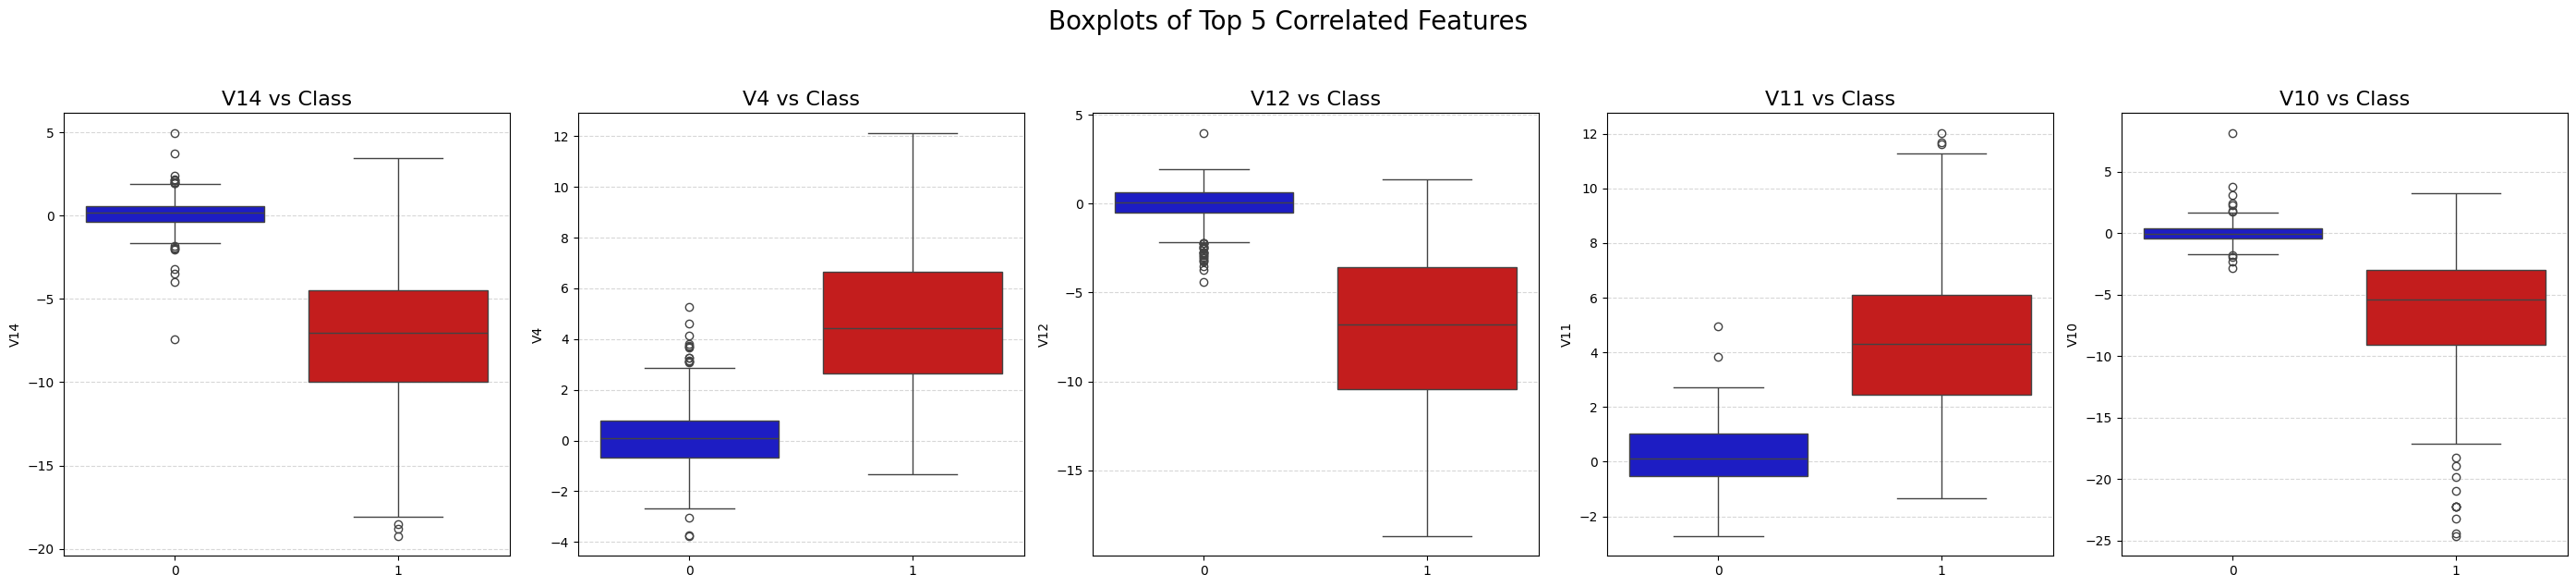

In [47]:


# 1. 상관계수 절댓값 기준 상위 5개 피처 자동 추출

# sub_train의 상관행렬 계산
corr_matrix = sub_train.corr()

# Class와의 상관계수 절댓값을 기준으로 내림차순 정렬 후 상위 5개 이름만 뽑기
top5_cols = corr_matrix['Class'].drop('Class').abs().sort_values(ascending=False).head(5).index.tolist()

print(f"✅ 분석된 Top 5 피처 목록: {top5_cols}")

# ---------------------------------------------------------
# 2. 캔버스 설정 (1행 5열로 변경)
# ---------------------------------------------------------
# 그래프가 5개이므로 가로 사이즈를 24에서 28로 조금 늘렸습니다.
f, axes = plt.subplots(ncols=5, figsize=(28, 6))

# 색상 설정 (파란색: 정상, 빨간색: 사기)
colors = ["#0101DF", "#DF0101"]

# ---------------------------------------------------------
# 3. 반복문을 돌며 그래프 그리기
# ---------------------------------------------------------
for i, col in enumerate(top5_cols):
    sns.boxplot(x="Class", y=col, data=sub_train, palette=colors, ax=axes[i])

    # 그래프 제목 및 스타일 설정
    axes[i].set_title(f'{col} vs Class', fontsize=16)
    axes[i].set_xlabel('') # x축 라벨(Class) 중복 제거
    axes[i].grid(axis='y', linestyle='--', alpha=0.5) # 격자선 추가

plt.suptitle('Boxplots of Top 5 Correlated Features', fontsize=20, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 역시 상관계수가 높아서 0 1 차이가 큼
#ㅡㅡㅡㅡㅡㅡ 특히 1인 경우의 이상치에 주목해서 처리할 생각

#ㅡㅡㅡㅡㅡㅡ 왜 개수 모자라서 아까운 Class 1 데이터를 지우느냐?
#ㅡㅡㅡㅡㅡㅡ Class 0 1 데이터의 결정경계를 분명하게 나눠줄 생각
#ㅡㅡㅡㅡㅡㅡ 그럼 모델이 더 확실히 구분할 수 있을 것을 기대

#ㅡㅡㅡㅡㅡㅡ 박스플롯에서 V14, V11, V10 이상치가 보임
#ㅡㅡㅡㅡㅡㅡ 정보 손실 최소화하는 값을 계산해서 제거할 생각
#ㅡㅡㅡㅡㅡㅡ max_loss_limit 값을 내가 조절하면서 결과를 관찰할 수 있도록 했음

In [48]:


# 1. 설정

target_features = ['V14', 'V11', 'V10']  # 처리할 피처
max_loss_limit = 0.03             # 허용할 최대 정보 손실률 (3%)


total_fraud_count = len(sub_train[sub_train['Class'] == 1])
best_factor = 1.5  # 초기값 (못 찾으면 기본 1.5 사용)

print(f"[{'Factor':^6}] | {'삭제 예상':^8} | {'손실률(%)':^10} | {'판단'}")
print("-" * 50)


# 2. 최적의 Factor 찾기 (시뮬레이션)

# 1.5부터 5.0까지 0.1단위로 늘려가며 확인
for factor in np.arange(1.5, 5.1, 0.1):
    temp_indices = []

    for col in target_features:
        fraud_data = sub_train[sub_train['Class'] == 1][col]
        q25 = np.percentile(fraud_data.values, 25)
        q75 = np.percentile(fraud_data.values, 75)
        iqr = q75 - q25

        cut_off = iqr * factor
        lower = q25 - cut_off
        upper = q75 + cut_off

        # 범위 벗어나는 인덱스 수집
        outliers = fraud_data[(fraud_data < lower) | (fraud_data > upper)].index
        temp_indices.extend(outliers)

    # 중복 제거한 실제 삭제 개수
    unique_count = len(set(temp_indices))
    loss_rate = unique_count / total_fraud_count

    status = "✅ 안전" if loss_rate <= max_loss_limit else "❌ 위험"
    print(f"[{factor:.1f} ] | {unique_count:^12} | {loss_rate*100:6.2f}%    | {status}")

    # 안전 범위에 들어오는 첫 번째 값(가장 타이트한 값)을 찾으면 중단
    if loss_rate <= max_loss_limit:
        best_factor = factor
        break

print("-" * 50)
print(f"🎯 최종 선택된 최적 Multiplier: {best_factor:.1f}")
print(f"   -> 정보 손실을 {max_loss_limit*100}% 이내로 방어하면서 가장 공격적으로 이상치를 제거합니다.")



# 3. 확정된 Factor로 실제 삭제 수행 및 상세 리포트

final_drop_indices = []
report = []

for col in target_features:
    fraud_data = sub_train[sub_train['Class'] == 1][col]
    q25 = np.percentile(fraud_data.values, 25)
    q75 = np.percentile(fraud_data.values, 75)
    iqr = q75 - q25

    cut_off = iqr * best_factor
    lower = q25 - cut_off
    upper = q75 + cut_off

    outliers = fraud_data[(fraud_data < lower) | (fraud_data > upper)].index
    final_drop_indices.extend(outliers)

    report.append({
        'Feature': col,
        'Lower_Limit': lower,
        'Upper_Limit': upper,
        'Outliers_Found': len(outliers)
    })

# 중복 인덱스 제거 후 삭제
final_drop_indices = list(set(final_drop_indices))
sub_train_processed = sub_train.drop(final_drop_indices)

# 결과 리포트 출력
print(f"\n[처리 결과]")
print(f"총 사기 데이터 수: {total_fraud_count}")
print(f"삭제된 데이터 수 : {len(final_drop_indices)}")
print(f"최종 정보 손실률 : {(len(final_drop_indices)/total_fraud_count)*100:.2f}%")

display(pd.DataFrame(report))

[Factor] |  삭제 예상   |   손실률(%)   | 판단
--------------------------------------------------
[1.5 ] |      14      |   3.89%    | ❌ 위험
[1.6 ] |      11      |   3.06%    | ❌ 위험
[1.7 ] |      9       |   2.50%    | ✅ 안전
--------------------------------------------------
🎯 최종 선택된 최적 Multiplier: 1.7
   -> 정보 손실을 3.0% 이내로 방어하면서 가장 공격적으로 이상치를 제거합니다.

[처리 결과]
총 사기 데이터 수: 360
삭제된 데이터 수 : 9
최종 정보 손실률 : 2.50%


,Feature,Lower_Limit,Upper_Limit,Outliers_Found
0,V14,-19.394085,4.942108,0
1,V11,-3.756427,12.298908,0
2,V10,-19.433012,7.392423,9


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 값을 3%와 5%정도로 바꿔가면서 확인해봤음
#ㅡㅡㅡㅡㅡㅡ 3%로 설정하면 2.50%의 정보손실이 있음
#ㅡㅡㅡㅡㅡㅡ 5%로 설정하면 3.89%의 정보손실이 있음

#ㅡㅡㅡㅡㅡㅡ 2.5%로 결정함
#ㅡㅡㅡㅡㅡㅡ 사실 아래에 t-SNE까지 같이 보고 돌아와서 다시 정했음

#ㅡㅡㅡㅡㅡㅡ t-SNE 등의 시각화로 정말 결정경계가 뚜려샣졌는지 확인
#ㅡㅡㅡㅡㅡㅡ 지우지 않았을 때와 비교해서 확실히 결정경계가 뚜렷해짐

시각화에 사용할 데이터 크기: (711, 30)
t-SNE 소요 시간: 6.37 s
PCA 소요 시간: 0.00 s
Truncated SVD 소요 시간: 0.00 s


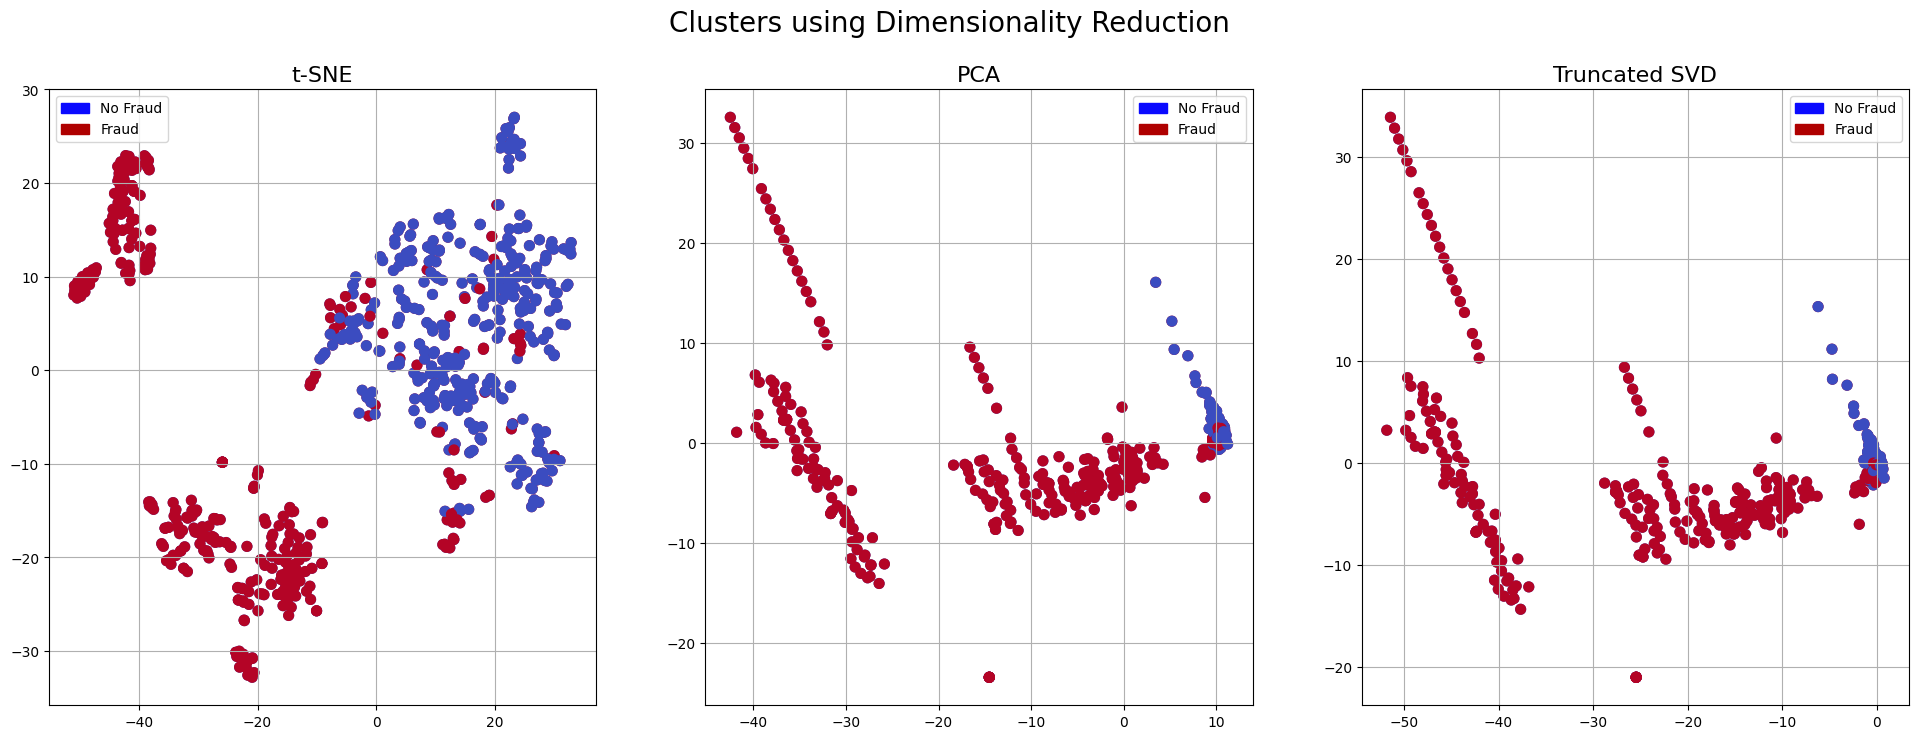

In [49]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

# 1. 데이터 준비 (이상치 제거된 데이터 사용)
# Class 컬럼을 제외한 피처들(X)과 Class(y) 분리
X = sub_train_processed.drop('Class', axis=1)
y = sub_train_processed['Class']

print(f"시각화에 사용할 데이터 크기: {X.shape}")

# ---------------------------------------------------------
# 2. 차원 축소 알고리즘 적용 (t-SNE, PCA, SVD)
# ---------------------------------------------------------

# t-SNE (가장 중요)
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print(f"t-SNE 소요 시간: {t1 - t0:.2f} s")

# PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print(f"PCA 소요 시간: {t1 - t0:.2f} s")

# Truncated SVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print(f"Truncated SVD 소요 시간: {t1 - t0:.2f} s")

# ---------------------------------------------------------
# 3. 시각화 (3개 알고리즘 비교)
# ---------------------------------------------------------
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
# 제목 설정
f.suptitle('Clusters using Dimensionality Reduction', fontsize=20)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# 1) t-SNE 시각화
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=16)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# 2) PCA 시각화
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=16)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# 3) Truncated SVD 시각화
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=16)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 이렇게 준비한 50:50 서브셋을 로지스틱 회귀에게 학습시킬 생각
#ㅡㅡㅡㅡㅡㅡ 방금 Class 1 데이터를 지워서 비율이 깨졌으므로 비율 다시 맞춰주기

#ㅡㅡㅡㅡㅡㅡ 본 케글 분류 컴퍼티션 평가 지표는 F1으로 공지되어있지만
#ㅡㅡㅡㅡㅡㅡ 임계점에 따라 값이 너무 달라지므로 F1을 기준으로 학습하지 않았음
#ㅡㅡㅡㅡㅡㅡ 밑에서도 계속 나오지만 모든 모델을 AUPRC(=PR-AUC)를 기준으로만 학습하였음
#ㅡㅡㅡㅡㅡㅡ 이것이 무척 중요함. 항상 체크해주었음
#ㅡㅡㅡㅡㅡㅡ 최고 F1점수는 전부 끝내고 마지막에 임계점 조절로 뽑아내도록 한다

In [50]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# ---------------------------------------------------------
# 1. 50:50 비율 다시 맞추기 (기존과 동일)
# ---------------------------------------------------------
# (데이터 처리 과정은 그대로 유지합니다)
# fraud_final, normal_final은 이미 정의되어 있다고 가정
# sub_train_processed 데이터가 로드되어 있어야 합니다.

fraud_final = sub_train_processed[sub_train_processed['Class'] == 1]
normal_final = sub_train_processed[sub_train_processed['Class'] == 0]

print(f"이상치 제거 후 사기 데이터 수: {len(fraud_final)}")
print(f"기존 정상 데이터 수: {len(normal_final)}")

# 사기 데이터 수에 맞춰서 정상 데이터 랜덤 샘플링 (줄이기)
normal_final_downsampled = normal_final.sample(n=len(fraud_final), random_state=42)

# 두 데이터 합치기 및 섞기
final_df = pd.concat([fraud_final, normal_final_downsampled])
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("-" * 30)
print(f"최종 학습 데이터셋(final_df) 크기: {final_df.shape}")
print(f"클래스 분포:\n{final_df['Class'].value_counts()}")
print("-" * 30)

# ---------------------------------------------------------
# 2. 로지스틱 회귀 모델 학습 (층화 교차 검증 + AUPRC)
# ---------------------------------------------------------
X_final = final_df.drop('Class', axis=1)
y_final = final_df['Class']

model_lr = LogisticRegression(max_iter=1000)

# StratifiedKFold 객체 생성 (데이터 섞기 포함)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# [수정됨] skf()가 아니라 cross_val_score() 함수를 써야 합니다.
# [수정됨] scoring='average_precision'이 AUPRC 점수를 뜻합니다.
scores = cross_val_score(model_lr, X_final, y_final, cv=skf, scoring='average_precision')

print("\n>>> Logistic Regression 성능 평가 (AUPRC) <<<")
print(f"교차 검증 AUPRC 점수 목록: {scores}")
print(f"평균 AUPRC: {round(scores.mean(), 4)}") # 보통 AUPRC는 소수점 4자리까지 봅니다.

이상치 제거 후 사기 데이터 수: 351
기존 정상 데이터 수: 360
------------------------------
최종 학습 데이터셋(final_df) 크기: (702, 31)
클래스 분포:
Class
0    351
1    351
Name: count, dtype: int64
------------------------------

>>> Logistic Regression 성능 평가 (AUPRC) <<<
교차 검증 AUPRC 점수 목록: [0.98305874 0.97724461 0.98176812 0.97908318 0.99821406]
평균 AUPRC: 0.9839


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 그리드서치CV로 로지스틱 회귀 모델 튜닝을 실시함

>>> 하이퍼파라미터 튜닝 중 (AUPRC 기준)...
최적의 파라미터(C): {'C': 0.01, 'penalty': 'l2'}
최고 AUPRC 점수: 0.9854


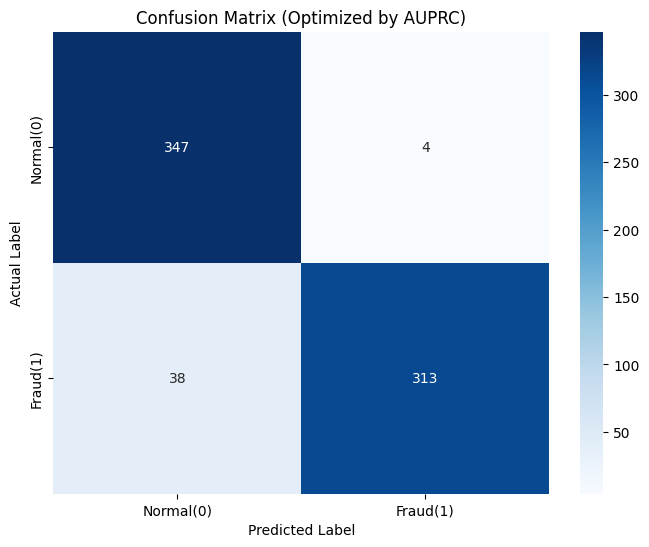


>>> 상세 분류 리포트 <<<
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       351
           1       0.99      0.89      0.94       351

    accuracy                           0.94       702
   macro avg       0.94      0.94      0.94       702
weighted avg       0.94      0.94      0.94       702



In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# ---------------------------------------------------------
# 8. 심화 학습: 로지스틱 회귀 튜닝 (GridSearchCV)
# ---------------------------------------------------------

# 1. 튜닝할 파라미터 그리드 설정
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'] # l2 규제 사용
}

# 2. GridSearchCV 객체 생성
# scoring='average_precision': AUPRC 점수를 기준으로 최적의 파라미터를 찾습니다.
# cv=skf: 앞서 정의한 StratifiedKFold 객체 사용
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='lbfgs'),
    param_grid,
    cv=skf,
    scoring='average_precision',
    n_jobs=-1
)

# 3. 학습 수행
print(">>> 하이퍼파라미터 튜닝 중 (AUPRC 기준)...")
grid_search.fit(X_final, y_final)

# 4. 최적의 파라미터 및 점수 출력
print(f"최적의 파라미터(C): {grid_search.best_params_}")
print(f"최고 AUPRC 점수: {grid_search.best_score_:.4f}")

# ---------------------------------------------------------
# 혼동 행렬 (Confusion Matrix) 시각화
# ---------------------------------------------------------
# 최적의 모델(best_estimator_)로 예측 수행
# predict()는 기본 임계값(0.5)을 기준으로 0과 1을 나눕니다.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_final)

# 혼동 행렬 계산
cm = confusion_matrix(y_final, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal(0)', 'Fraud(1)'],
            yticklabels=['Normal(0)', 'Fraud(1)'])
plt.title('Confusion Matrix (Optimized by AUPRC)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 상세 리포트 출력
print("\n>>> 상세 분류 리포트 <<<")
print(classification_report(y_final, y_pred))

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 튜닝을 하였으나 성능이 이상해서 확인해보니 임계값 설정이 서브셋 기준으로 되어있었음
#ㅡㅡㅡㅡㅡㅡ 전체 데이터 기준으로 최적 임계점을 다시 찾아줌

In [52]:

from sklearn.metrics import precision_recall_curve

# ---------------------------------------------------------
# 9. 최적 임계값(Threshold) 찾기
# ---------------------------------------------------------
# 1. 학습 데이터(X_final)에 대한 예측 확률(Probability)을 구합니다.
# predict_proba 결과의 [:, 1]은 '사기(1)'일 확률입니다.
y_prob_train = best_model.predict_proba(X_final)[:, 1]

# 2. 정밀도(Precision), 재현율(Recall), 임계값(Threshold) 후보들을 계산
precisions, recalls, thresholds = precision_recall_curve(y_final, y_prob_train)

# 3. 각 임계값마다 F1 Score 계산
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# 분모가 0이 되는 경우를 대비해 나눗셈 안전 처리
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores) # NaN을 0으로 변환

# 4. F1 Score가 최대가 되는 인덱스와 임계값 찾기
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f">>> 최적 임계값 탐색 결과 <<<")
print(f"최적 임계값 (Threshold): {best_threshold:.4f}")
print(f"해당 임계값에서의 학습 데이터 F1 Score: {best_f1:.4f}")

# ---------------------------------------------------------
# 10. Test 데이터 예측 및 Submission 생성
# ---------------------------------------------------------
# [주의] Test 데이터도 학습 데이터와 동일한 전처리가 되어 있어야 합니다!
# X_final에 있는 컬럼만 test 데이터에서 선택 (순서 보장)
# 만약 test 데이터에 'ID' 같은 불필요한 컬럼이 있다면 제외됩니다.
X_test = test[X_final.columns].copy()

# 1. Test 데이터 예측 확률 구하기
y_prob_test = best_model.predict_proba(X_test)[:, 1]

# 2. 최적 임계값 적용하여 0, 1로 변환
final_preds = (y_prob_test >= best_threshold).astype(int)

# 3. Submission 파일 만들기
submission['Class'] = final_preds
submission.to_csv('submission.csv', index=False)

print("\n>>> submission.csv 생성 완료! <<<")
print(submission['Class'].value_counts()) # 0과 1의 분포 확인

>>> 최적 임계값 탐색 결과 <<<
최적 임계값 (Threshold): 0.2397
해당 임계값에서의 학습 데이터 F1 Score: 0.9511

>>> submission.csv 생성 완료! <<<
Class
0    107198
1      6725
Name: count, dtype: int64


In [53]:

from sklearn.metrics import precision_recall_curve, f1_score

# ---------------------------------------------------------
# [수정] 진짜 원본 데이터 로드 및 임계값 찾기
# ---------------------------------------------------------

# 1. 원본 train 데이터 다시 불러오기 (경로 확인 필요)
full_train_df = train.copy() # 혹은 기존에 로드해둔 원본 변수 사용

# 2. 전처리 (매우 중요: 학습 때와 똑같이 해줘야 함)
# 'ID' 컬럼이 있다면 제거 (학습에 안 썼으니까)
if 'id' in full_train_df.columns:
    full_train_df = full_train_df.drop('id', axis=1)

# X, y 분리
X_full_real = full_train_df.drop('Class', axis=1)
y_full_real = full_train_df['Class']

# [중요] 스케일링 적용
# 학습할 때 사용했던 로버스트 스케일러(scaler) 객체가 메모리에 있다면 그걸로 transform 해야 합니다.
# 만약 scaler 객체 변수명이 'scaler'라면 아래 주석 해제 후 실행:
# X_full_real[X_full_real.columns] = scaler.transform(X_full_real)

# ※ 만약 scaler 객체가 없다면, test셋 만들 때 썼던 방식 그대로 스케일링을 다시 해줘야 합니다.
# (여기서는 작성자님이 이미 test셋에 로버스트 스케일링을 했다고 했으므로,
#  원본 train에도 똑같이 적용되어 있다고 가정하거나, 아래처럼 직접 적용해야 합니다.)
# from sklearn.preprocessing import RobustScaler
# rob_scaler = RobustScaler()
# X_full_real[col_names] = rob_scaler.fit_transform(X_full_real[col_names])
# -> 주의: 이미 학습된 모델과 스케일이 맞아야 함.
# -> 가장 좋은 건 학습 때 쓴 scaler.transform(X_full_real) 입니다.

# 학습 데이터 컬럼 순서 맞추기 (안전장치)
X_full_real = X_full_real[X_final.columns]

print(f"진짜 원본 데이터 크기: {X_full_real.shape}")
print(f"진짜 원본 사기 비율: {y_full_real.mean() * 100:.4f}% (0.2% 근처여야 함)")

# 3. 모델 예측 (전체 데이터 대상)
# 모델은 50:50으로 학습했지만, 예측은 28만 건 전체에 대해 수행
y_prob_full_real = best_model.predict_proba(X_full_real)[:, 1]

# 4. 정밀도-재현율 곡선으로 최적 임계값 찾기
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_full_real)

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold_final = thresholds[best_idx]
best_f1_final = f1_scores[best_idx]

print("-" * 30)
print(f">>> 최종 보정된 임계값 결과 <<<")
print(f"기존 임계값: {best_threshold:.4f}")
print(f"최종 임계값: {best_threshold_final:.4f} (이 값이 0.9 이상 나와야 정상)")
print(f"예상 F1 Score: {best_f1_final:.4f}")
print("-" * 30)

# ---------------------------------------------------------
# Submission 생성 (최종)
# ---------------------------------------------------------
# Test 데이터 예측값 (이미 구해둔 y_prob_test 사용 가능)
# 혹시 모르니 다시 계산
X_test = test[X_final.columns]
y_prob_test = best_model.predict_proba(X_test)[:, 1]

# 최종 임계값 적용
final_preds_submission = (y_prob_test >= best_threshold_final).astype(int)

submission['Class'] = final_preds_submission
submission.to_csv('submission_final.csv', index=False)

print(">>> submission_final.csv 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")

진짜 원본 데이터 크기: (170883, 30)
진짜 원본 사기 비율: 0.2107% (0.2% 근처여야 함)
------------------------------
>>> 최종 보정된 임계값 결과 <<<
기존 임계값: 0.2397
최종 임계값: 0.9382 (이 값이 0.9 이상 나와야 정상)
예상 F1 Score: 0.7382
------------------------------
>>> submission_final.csv 생성 완료.
예측된 사기 거래 수: 170


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 모델이 너무 작아서 성능이 별로였음
#ㅡㅡㅡㅡㅡㅡ 성능을 향상시킬 방안을 궁리함

#ㅡㅡㅡㅡㅡㅡ 이지엔셈블(easyensemble)을 선택

#ㅡㅡㅡㅡㅡㅡ 정상 데이터를 아까 모아놓은 사기데이터 비율만큼 무작위 추출함
#ㅡㅡㅡㅡㅡㅡ 이것을 '비복원' 추출로 정상데이터가 모두 떨어질 때까지 실시함
#ㅡㅡㅡㅡㅡㅡ 모든 정상데이터를 사용할 수 있음
#ㅡㅡㅡㅡㅡㅡ 사기데이터는 그렇게 뽑아놓은 K개의 정상데이터 서브셋에 하나씩 복사해서 넣어줌
#ㅡㅡㅡㅡㅡㅡ 모든 데이터를 낭비없이 사용하면서도 50:50 서브셋을 많이 만들 수 있음
#ㅡㅡㅡㅡㅡㅡ 이제 이 서브셋마다 학습기를 하나씩 붙여줌

In [54]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

# ---------------------------------------------------------
# 1. 데이터 준비 (fraud_final 활용)
# ---------------------------------------------------------

# 1) 사기 데이터: 사용자가 지정한 'fraud_final' 사용 (이상치 제거됨)
X_fraud = fraud_final.drop('Class', axis=1)
y_fraud = fraud_final['Class']

# 2) 정상 데이터: 전체 원본 데이터(X_full_real)에서 가져오기
# (X_full_real, y_full_real은 직전 단계에서 생성된 원본 스케일링 데이터입니다)
X_normal_all = X_full_real[y_full_real == 0]
y_normal_all = y_full_real[y_full_real == 0]

# [중요] 컬럼 순서 및 종류 동기화 (에러 방지)
X_normal_all = X_normal_all[X_fraud.columns]

# 3) 개수 자동 계산
n_fraud = len(X_fraud)          # 정제된 사기 데이터 개수
n_normal = len(X_normal_all)    # 전체 정상 데이터 개수
n_bags = n_normal // n_fraud    # 만들 모델 개수 (몫)

print(f"사용할 사기 데이터 수(n_fraud): {n_fraud}")
print(f"전체 정상 데이터 수: {n_normal}")
print(f">>> 총 {n_bags}개의 모델을 학습합니다 (정상 데이터를 {n_bags}등분).")

# ---------------------------------------------------------
# 2. EasyEnsemble 학습 Loop
# ---------------------------------------------------------
# 정상 데이터 섞기 (랜덤성을 위해)
X_normal_shuffled = X_normal_all.sample(frac=1, random_state=42).reset_index(drop=True)

models = [] # 학습된 모델들을 저장할 리스트

print("\n>>> 학습 시작...")
for i in range(n_bags):
    # 1. 정상 데이터 슬라이싱 (비복원 추출)
    # 0~n, n~2n, 2n~3n ... 순서대로 가져옴
    start = i * n_fraud
    end = (i + 1) * n_fraud

    X_normal_subset = X_normal_shuffled.iloc[start:end]
    y_normal_subset = pd.Series([0] * len(X_normal_subset)) # 라벨 0 생성

    # 2. 학습 데이터셋 결합 (Clean Fraud + Random Normal)
    X_train_bag = pd.concat([X_fraud, X_normal_subset])
    y_train_bag = pd.concat([y_fraud, y_normal_subset])

    # 3. 모델 학습
    model = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)
    model.fit(X_train_bag, y_train_bag)

    models.append(model)

    # 진행 상황 출력 (50개 단위)
    if (i + 1) % 50 == 0:
        print(f"[{i + 1}/{n_bags}] 모델 학습 중...")

print(">>> 모든 모델 학습 완료!")

# ---------------------------------------------------------
# 3. 앙상블 확률 계산 (전체 데이터 대상)
# ---------------------------------------------------------
print("\n>>> 최적 임계값을 찾기 위해 전체 데이터 예측 중...")

# 전체 데이터(X_full_real)에 대해 모든 모델의 확률을 더함
probs_sum = np.zeros(len(X_full_real))

# X_full_real의 컬럼 순서도 X_fraud와 맞춰줌 (안전장치)
X_full_for_predict = X_full_real[X_fraud.columns]

for model in models:
    probs_sum += model.predict_proba(X_full_for_predict)[:, 1]

# 평균 확률 계산
y_prob_ensemble = probs_sum / n_bags

# ---------------------------------------------------------
# 4. 최적 임계값(Threshold) 찾기
# ---------------------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble)

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold_ee = thresholds[best_idx]
best_f1_ee = f1_scores[best_idx]

print("-" * 30)
print(f">>> EasyEnsemble 결과 <<<")
print(f"최적 임계값: {best_threshold_ee:.4f}")
print(f"예상 F1 Score: {best_f1_ee:.4f}")
print("-" * 30)

# ---------------------------------------------------------
# 5. Submission 생성
# ---------------------------------------------------------
print(">>> Test 데이터 예측 및 파일 생성 중...")

X_test = test[X_fraud.columns] # 컬럼 순서 맞추기

# Test 데이터에 대해 앙상블 예측
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test_ee = test_probs_sum / n_bags

# 최적 임계값 적용
final_preds_ee = (y_prob_test_ee >= best_threshold_ee).astype(int)

submission['Class'] = final_preds_ee
submission.to_csv('submission_easy_ensemble.csv', index=False)

print(">>> submission_easy_ensemble.csv 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")

사용할 사기 데이터 수(n_fraud): 351
전체 정상 데이터 수: 170523
>>> 총 485개의 모델을 학습합니다 (정상 데이터를 485등분).

>>> 학습 시작...
[50/485] 모델 학습 중...
[100/485] 모델 학습 중...
[150/485] 모델 학습 중...
[200/485] 모델 학습 중...
[250/485] 모델 학습 중...
[300/485] 모델 학습 중...
[350/485] 모델 학습 중...
[400/485] 모델 학습 중...
[450/485] 모델 학습 중...
>>> 모든 모델 학습 완료!

>>> 최적 임계값을 찾기 위해 전체 데이터 예측 중...
------------------------------
>>> EasyEnsemble 결과 <<<
최적 임계값: 0.9955
예상 F1 Score: 0.8220
------------------------------
>>> Test 데이터 예측 및 파일 생성 중...
>>> submission_easy_ensemble.csv 생성 완료.
예측된 사기 거래 수: 137


In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve

# ---------------------------------------------------------
# 로지스틱 회귀 EasyEnsemble: 임계값 최적화 및 제출 파일 재생성
# ---------------------------------------------------------

# 1. 전체 학습 데이터(X_full_real)에 대한 앙상블 확률값 계산
print(">>> [로지스틱 회귀] 전체 데이터 확률 계산 및 임계값 최적화 시작...")

# 컬럼 순서 강제 일치 (학습 데이터 기준)
X_full_opt = X_full_real[X_fraud.columns]

# 기존에 학습된 models 리스트를 사용
probs_sum_train = np.zeros(len(X_full_opt))

for model in models:
    probs_sum_train += model.predict_proba(X_full_opt)[:, 1]

# 평균 확률 (Soft Voting)
y_prob_ensemble_train = probs_sum_train / len(models)

# 2. 정밀도-재현율 곡선을 통해 최적 임계값 찾기
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble_train)

# F1 Score 계산
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

# 최적 위치 찾기
best_idx = np.argmax(f1_scores)
best_threshold_lr = thresholds[best_idx]
best_f1_lr = f1_scores[best_idx]

print("-" * 30)
print(f">>> 로지스틱 EasyEnsemble 최적화 결과 <<<")
print(f"최적 임계값: {best_threshold_lr:.4f}")
print(f"예상 F1 Score: {best_f1_lr:.4f}")
print("-" * 30)

# 3. Test 데이터에 적용 및 Submission 저장
print(">>> Test 데이터 예측 값에 최적 임계값 적용 중...")

# Test 데이터 준비
X_test_lr = test[X_fraud.columns]

# Test 데이터 확률 계산 (이미 계산된 게 변수에 있다면 그걸 써도 되지만, 안전하게 다시 계산)
probs_sum_test = np.zeros(len(X_test_lr))

for model in models:
    probs_sum_test += model.predict_proba(X_test_lr)[:, 1]

y_prob_ensemble_test = probs_sum_test / len(models)

# 최적 임계값 적용하여 0, 1 생성
final_preds_lr = (y_prob_ensemble_test >= best_threshold_lr).astype(int)

# 저장
submission['Class'] = final_preds_lr
submission.to_csv('submission_easy_ensemble_lr_optimized.csv', index=False)

print(">>> submission_easy_ensemble_lr_optimized.csv 생성 완료.")
print(f"최종 예측된 사기 거래 수: {submission['Class'].sum()}")

>>> [로지스틱 회귀] 전체 데이터 확률 계산 및 임계값 최적화 시작...
------------------------------
>>> 로지스틱 EasyEnsemble 최적화 결과 <<<
최적 임계값: 0.9955
예상 F1 Score: 0.8220
------------------------------
>>> Test 데이터 예측 값에 최적 임계값 적용 중...
>>> submission_easy_ensemble_lr_optimized.csv 생성 완료.
최종 예측된 사기 거래 수: 137


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 위는 이지엔셈블_로지스틱회귀 였음
#ㅡㅡㅡㅡㅡㅡ 아래는 이지엔셈블_LGBM을 실시함
#ㅡㅡㅡㅡㅡㅡ 그리드서치CV로 튜닝도 함께 진행함
#ㅡㅡㅡㅡㅡㅡ 소요시간 매우 오래 걸리니 주의 (약 1시간)

In [56]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, f1_score

# ---------------------------------------------------------
# 1. 데이터 준비 (전처리 완료된 데이터 로드)
# ---------------------------------------------------------
# 1) 사기 데이터: 정제된 sub_train_processed 사용
fraud_data = sub_train_processed[sub_train_processed['Class'] == 1]
X_fraud = fraud_data.drop('Class', axis=1)
y_fraud = fraud_data['Class']

# 2) 정상 데이터: 전체 원본(X_full_real)에서 가져옴
X_normal_all = X_full_real[y_full_real == 0]
y_normal_all = y_full_real[y_full_real == 0]

# [중요] 컬럼 순서 강제 동기화
X_normal_all = X_normal_all[X_fraud.columns]

# 3) Bagging 개수 계산
n_fraud = len(X_fraud)
n_bags = len(X_normal_all) // n_fraud

print(f">>> [데이터 준비 완료]")
print(f" - 사기 데이터 수: {n_fraud}")
print(f" - 정상 데이터 수: {len(X_normal_all)}")
print(f" - 생성할 모델(Bags) 수: {n_bags}개")

from sklearn.model_selection import StratifiedKFold # 이거 import 필수

# ... (앞부분 데이터 준비 코드는 동일) ...

# ---------------------------------------------------------
# 2. 정밀 튜닝 (GridSearchCV + StratifiedKFold 명시)
# ---------------------------------------------------------
print("\n>>> [1단계] 최적의 파라미터 탐색 (GridSearchCV + Stratified K-Fold)...")

# 튜닝용 대표 데이터셋 (1:1 비율)
X_normal_sample = X_normal_all.sample(n=n_fraud, random_state=42)
y_normal_sample = pd.Series([0] * n_fraud)

X_tune = pd.concat([X_fraud, X_normal_sample])
y_tune = pd.concat([y_fraud, y_normal_sample])

# [수정됨] 층화 K폴드 객체 명시적 생성 (섞기 포함)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [5, 10, 20, -1],
    'min_child_samples': [10, 20, 30]
}

lgbm = LGBMClassifier(random_state=42, verbose=-1, n_jobs=1)

# GridSearchCV 실행
grid_search = GridSearchCV(
    lgbm,
    param_grid,
    cv=skf,               # [수정됨] 숫자 5 대신 skf 객체 전달 -> 확실하게 층화+섞기 적용
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_tune, y_tune)

best_params = grid_search.best_params_
print(f"\n✅ 최적 파라미터 발견: {best_params}")
print(f"✅ 최고 AUPRC 점수: {grid_search.best_score_:.4f}")

# ... (이후 EasyEnsemble 학습 및 임계값 최적화 코드는 그대로 실행) ...

# ---------------------------------------------------------
# 3. EasyEnsemble 학습 (최적 파라미터 적용)
# ---------------------------------------------------------
print(f"\n>>> [2단계] EasyEnsemble 학습 시작 ({n_bags}개 모델)...")

# 정상 데이터 섞기
X_normal_shuffled = X_normal_all.sample(frac=1, random_state=42).reset_index(drop=True)
models = []

for i in range(n_bags):
    start = i * n_fraud
    end = (i + 1) * n_fraud

    # 정상 데이터 슬라이싱
    X_normal_subset = X_normal_shuffled.iloc[start:end]
    y_normal_subset = pd.Series([0] * len(X_normal_subset))

    # 데이터 결합
    X_train_bag = pd.concat([X_fraud, X_normal_subset])
    y_train_bag = pd.concat([y_fraud, y_normal_subset])

    # [핵심] 찾은 최적 파라미터(**best_params) 적용
    model = LGBMClassifier(**best_params, random_state=42, verbose=-1, n_jobs=1)
    model.fit(X_train_bag, y_train_bag)
    models.append(model)

    if (i + 1) % 50 == 0:
        print(f" - [{i + 1}/{n_bags}] 모델 학습 완료")

print(">>> 모든 모델 학습 완료!")

# ---------------------------------------------------------
# 4. 앙상블 확률 계산 (Soft Voting)
# ---------------------------------------------------------
print("\n>>> [3단계] 전체 데이터에 대한 앙상블 확률 계산 중...")

# 전체 원본 데이터(X_full_real) 컬럼 맞추기
X_full_predict = X_full_real[X_fraud.columns]

# 누적 확률 변수
probs_sum = np.zeros(len(X_full_predict))

# 모든 모델의 예측값 합산
for model in models:
    probs_sum += model.predict_proba(X_full_predict)[:, 1]

# 평균 계산
y_prob_ensemble = probs_sum / n_bags

# ---------------------------------------------------------
# 5. 최종 임계값 최적화 (F1 Score 기준)
# ---------------------------------------------------------
print(">>> [4단계] 최고 F1 점수를 위한 임계값(Threshold) 찾는 중...")

# Precision-Recall Curve 계산
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble)

# F1 Score 계산
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

# 최대 F1 위치 찾기
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("-" * 40)
print(f"🏆 최종 최적화 결과 🏆")
print(f"1. 학습 모델: LightGBM EasyEnsemble (GridSearch AUPRC)")
print(f"2. 최적 임계값: {best_threshold:.6f}")
print(f"3. 예상 최고 F1 Score: {best_f1:.6f}")
print("-" * 40)

# ---------------------------------------------------------
# 6. Submission 파일 생성
# ---------------------------------------------------------
print("\n>>> [5단계] Test 데이터 예측 및 제출 파일 생성...")

# Test 데이터 컬럼 정렬
X_test = test[X_fraud.columns]

# Test 데이터 확률 계산 (앙상블)
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test_ensemble = test_probs_sum / n_bags

# 최적 임계값 적용
final_preds = (y_prob_test_ensemble >= best_threshold).astype(int)

# 파일 저장
submission['Class'] = final_preds
filename = 'submission_lgbm_ensemble_grid_auprc.csv'
submission.to_csv(filename, index=False)

print(f">>> {filename} 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")

# 소요시간 3795초

>>> [데이터 준비 완료]
 - 사기 데이터 수: 351
 - 정상 데이터 수: 170523
 - 생성할 모델(Bags) 수: 485개

>>> [1단계] 최적의 파라미터 탐색 (GridSearchCV + Stratified K-Fold)...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

✅ 최적 파라미터 발견: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}
✅ 최고 AUPRC 점수: 0.9838

>>> [2단계] EasyEnsemble 학습 시작 (485개 모델)...
 - [50/485] 모델 학습 완료
 - [100/485] 모델 학습 완료
 - [150/485] 모델 학습 완료
 - [200/485] 모델 학습 완료
 - [250/485] 모델 학습 완료
 - [300/485] 모델 학습 완료
 - [350/485] 모델 학습 완료
 - [400/485] 모델 학습 완료
 - [450/485] 모델 학습 완료
>>> 모든 모델 학습 완료!

>>> [3단계] 전체 데이터에 대한 앙상블 확률 계산 중...
>>> [4단계] 최고 F1 점수를 위한 임계값(Threshold) 찾는 중...
----------------------------------------
🏆 최종 최적화 결과 🏆
1. 학습 모델: LightGBM EasyEnsemble (GridSearch AUPRC)
2. 최적 임계값: 0.999252
3. 예상 최고 F1 Score: 1.000000
----------------------------------------

>>> [5단계] Test 데이터 예측 및 제출 파일 생성...
>>> submission_lgbm_ensemble_grid_auprc.csv 생성 완료.
예측된 사기 거래 수: 99


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 예상 최고 F1 점수 1.0이라더니 내 기대를 배신함

#ㅡㅡㅡㅡㅡㅡ 이번엔 이지엔셈블과 비슷한 밸런스드 케스케이드를 실시함
#ㅡㅡㅡㅡㅡㅡ 사실 지금은 안 쓰이는 기법이지만 해보니 케글 점수는 잘 나왔음
#ㅡㅡㅡㅡㅡㅡ 이지엔셈블과 비슷한데, 이건 '하나씩 학습'하면서 '쉬운 정답은 다음에 제외'함
#ㅡㅡㅡㅡㅡㅡ 아래는 Balanced Cascade를 Catboost로 적용한 코드임

In [61]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# 1. 원본 데이터 로드
full_df = pd.read_csv('train.csv')

# 2. 전처리 (학습 데이터와 동일하게 만들기)
# 'ID' 컬럼이 있다면 제거
if 'id' in full_df.columns:
    full_df.drop('id', axis=1, inplace=True)

# 3. Robust Scaler 적용 ('Time', 'Amount')
# 새로운 컬럼 생성
rob_scaler = RobustScaler()
full_df['scaled_amount'] = rob_scaler.fit_transform(full_df['Amount'].values.reshape(-1,1))
full_df['scaled_time'] = rob_scaler.fit_transform(full_df['Time'].values.reshape(-1,1))

# 기존 컬럼 삭제
full_df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 4. X(데이터), y(라벨) 분리
X_full_real = full_df.drop('Class', axis=1)
y_full_real = full_df['Class']

# [중요] 컬럼 순서를 sub_train_processed와 강제로 맞춤 (에러 방지)
# sub_train_processed에서 Class를 제외한 컬럼 목록 가져오기
feature_cols = sub_train_processed.drop('Class', axis=1).columns
X_full_real = X_full_real[feature_cols]

print(">>> 원본 전체 데이터 로드 완료")
print(f"X_full_real 크기: {X_full_real.shape} (약 17만 건이어야 정상)")
print(f"y_full_real 크기: {y_full_real.shape}")

>>> 원본 전체 데이터 로드 완료
X_full_real 크기: (170883, 30) (약 17만 건이어야 정상)
y_full_real 크기: (170883,)


In [62]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. 데이터 준비
# ---------------------------------------------------------
# 사기(Fraud) 데이터와 정상(Normal) 데이터 분리
# (sub_train_processed, X_full_real, y_full_real, test 변수가 메모리에 있어야 합니다)

X_fraud = sub_train_processed[sub_train_processed['Class'] == 1].drop('Class', axis=1)
y_fraud = sub_train_processed[sub_train_processed['Class'] == 1]['Class']

X_normal_all = X_full_real[y_full_real == 0]
# 컬럼 순서 동기화
X_normal_all = X_normal_all[X_fraud.columns]

print(f"사기 데이터: {len(X_fraud)}")
print(f"정상 데이터: {len(X_normal_all)}")

# ---------------------------------------------------------
# 2. Balanced Cascade 학습 로직 (Hard Negative Mining)
# ---------------------------------------------------------
models = []
n_stages = 10  # 모델 개수
current_normal_pool = X_normal_all.copy() # 정상 데이터 풀

print(f"\n>>> Balanced Cascade (CatBoost + AUPRC) 학습 시작...")

for i in range(n_stages):
    # 1) 정상 데이터 언더샘플링 (사기 데이터 개수만큼)
    if len(current_normal_pool) < len(X_fraud):
        print(f"  [Info] 남은 정상 데이터가 부족하여 {i}단계에서 조기 종료합니다.")
        break

    # 랜덤하게 뽑되, random_state를 바꿔가며 다양성 확보
    X_normal_sample = current_normal_pool.sample(n=len(X_fraud), random_state=42+i)
    y_normal_sample = pd.Series([0] * len(X_normal_sample))

    # 2) 학습 데이터 생성 (1:1 비율)
    X_train = pd.concat([X_fraud, X_normal_sample])
    y_train = pd.concat([y_fraud, y_normal_sample])

    # 3) CatBoost 모델 학습
    # [수정] eval_metric='PRAUC'로 설정하여 학습 과정에서 AUPRC 최적화
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='PRAUC',  # AUPRC (Precision-Recall Area Under Curve)
        auto_class_weights=None,
        verbose=0,
        random_seed=42+i,
        allow_writing_files=False # 불필요한 파일 생성 방지
    )

    model.fit(X_train, y_train)
    models.append(model)

    # -----------------------------------------------------
    # [핵심] Hard Negative Mining (어려운 정상 데이터 남기기)
    # -----------------------------------------------------
    if i < n_stages - 1:
        # 전체 풀에 대해 예측
        probs = model.predict_proba(current_normal_pool)[:, 1]

        # 모델이 '정상'이라고 확신하지 못하는(사기일 확률이 조금이라도 있는) 데이터만 남김
        # threshold_filter: 이 값보다 확률이 높으면 "어려운 데이터"로 간주
        threshold_filter = 0.05
        hard_indices = np.where(probs > threshold_filter)[0]

        current_normal_pool = current_normal_pool.iloc[hard_indices]

        print(f" - Stage {i+1} 완료. 남은 '어려운' 정상 데이터: {len(current_normal_pool)}")

        if len(current_normal_pool) < len(X_fraud):
            print("  -> 남은 데이터가 너무 적어 루프를 종료합니다.")
            break
    else:
        print(f" - Stage {i+1} 완료 (마지막 단계)")

print(f">>> 총 {len(models)}개의 Cascade 모델 학습 완료.")

# ---------------------------------------------------------
# 3. 앙상블 예측 (Soft Voting)
# ---------------------------------------------------------
print("\n>>> 전체 데이터 예측 및 성능 평가...")

# 전체 원본 데이터(X_full_real)에 대해 예측
X_full_predict = X_full_real[X_fraud.columns]
probs_sum = np.zeros(len(X_full_predict))

for model in models:
    probs_sum += model.predict_proba(X_full_predict)[:, 1]

# 평균 확률 계산
y_prob_ensemble = probs_sum / len(models)

# ---------------------------------------------------------
# 4. 성능 평가 및 Threshold 최적화
# ---------------------------------------------------------
# [수정] AUPRC 점수 계산 및 출력
auprc_score = average_precision_score(y_full_real, y_prob_ensemble)
print(f"🏆 전체 앙상블 AUPRC Score: {auprc_score:.6f}")

# F1 Score 기준 최적 임계값 찾기 (제출용 0/1 생성을 위해 필수)
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble)

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🏆 최적 임계값 (Max F1): {best_threshold:.6f}")
print(f"🏆 예상 최고 F1 Score: {best_f1:.6f}")

# ---------------------------------------------------------
# 5. 제출 파일 생성
# ---------------------------------------------------------
X_test = test[X_fraud.columns]
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test = test_probs_sum / len(models)
final_preds = (y_prob_test >= best_threshold).astype(int)

submission['Class'] = final_preds
submission.to_csv('submission_catboost_cascade_auprc.csv', index=False)
print(">>> submission_catboost_cascade_auprc.csv 저장 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")


사기 데이터: 351
정상 데이터: 170523

>>> Balanced Cascade (CatBoost + AUPRC) 학습 시작...
 - Stage 1 완료. 남은 '어려운' 정상 데이터: 17001
 - Stage 2 완료. 남은 '어려운' 정상 데이터: 2771
 - Stage 3 완료. 남은 '어려운' 정상 데이터: 633
 - Stage 4 완료. 남은 '어려운' 정상 데이터: 88
  -> 남은 데이터가 너무 적어 루프를 종료합니다.
>>> 총 4개의 Cascade 모델 학습 완료.

>>> 전체 데이터 예측 및 성능 평가...
🏆 전체 앙상블 AUPRC Score: 0.988822
🏆 최적 임계값 (Max F1): 0.922514
🏆 예상 최고 F1 Score: 0.989011
>>> submission_catboost_cascade_auprc.csv 저장 완료.
예측된 사기 거래 수: 98


In [63]:
#ㅡㅡㅡㅡㅡㅡ 블랜스드 케스케이드 캣부스트도 튜닝을 실시함

In [64]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.stats import randint, uniform

# ---------------------------------------------------------
# 1. 데이터 준비 (원본 데이터 X_full_real 필요)
# ---------------------------------------------------------
# X_full_real, y_full_real이 메모리에 있어야 합니다.

# 사기 데이터 준비
X_fraud = sub_train_processed[sub_train_processed['Class'] == 1].drop('Class', axis=1)
y_fraud = sub_train_processed[sub_train_processed['Class'] == 1]['Class']

# 정상 데이터 준비
X_normal_all = X_full_real[y_full_real == 0]
X_normal_all = X_normal_all[X_fraud.columns] # 컬럼 순서 동기화

print(f"사기 데이터: {len(X_fraud)}")
print(f"정상 데이터: {len(X_normal_all)}")

# ---------------------------------------------------------
# 2. 하이퍼파라미터 튜닝 (대표 데이터셋 1개로 수행)
# ---------------------------------------------------------
print("\n>>> [1단계] 하이퍼파라미터 튜닝 시작 (RandomizedSearch + AUPRC)...")

# 튜닝용 대표 데이터셋 생성 (사기:정상 = 1:1)
X_normal_sample = X_normal_all.sample(n=len(X_fraud), random_state=42)
y_normal_sample = pd.Series([0] * len(X_fraud))

X_tune = pd.concat([X_fraud, X_normal_sample])
y_tune = pd.concat([y_fraud, y_normal_sample])

# 탐색할 파라미터 공간 정의
param_dist = {
    'iterations': randint(500, 1500),          # 트리 개수
    'learning_rate': uniform(0.01, 0.2),       # 학습률
    'depth': randint(4, 10),                   # 트리 깊이
    'l2_leaf_reg': randint(1, 10),             # L2 규제
    'random_strength': uniform(0.1, 10),       # 랜덤성 (과적합 방지)
    'bagging_temperature': uniform(0.0, 1.0),  # 배깅 강도
    'border_count': [32, 64, 128, 254]         # 수치형 변수 분할 수
}

# 기본 모델
# AUPRC 최적화를 위해 eval_metric='PRAUC' 설정
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',
    verbose=0,
    random_seed=42,
    allow_writing_files=False
)

# RandomizedSearchCV 설정
search = RandomizedSearchCV(
    cat_model,
    param_distributions=param_dist,
    n_iter=30,                     # 30번 시도 (시간에 따라 조절 가능)
    scoring='average_precision',   # AUPRC 기준 평가
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

search.fit(X_tune, y_tune)

best_params = search.best_params_
print(f"\n✅ 최적 파라미터 발견: {best_params}")
print(f"✅ 최고 AUPRC 점수 (CV): {search.best_score_:.4f}")

# ---------------------------------------------------------
# 3. Balanced Cascade 학습 (튜닝된 파라미터 적용)
# ---------------------------------------------------------
print(f"\n>>> [2단계] Balanced Cascade 학습 시작 (Hard Negative Mining)...")

models = []
n_stages = 10
current_normal_pool = X_normal_all.copy()

for i in range(n_stages):
    # 1) 정상 데이터 언더샘플링
    if len(current_normal_pool) < len(X_fraud):
        print(f"  [Info] 데이터 부족으로 {i}단계에서 종료.")
        break

    X_normal_sample = current_normal_pool.sample(n=len(X_fraud), random_state=42+i)
    y_normal_sample = pd.Series([0] * len(X_normal_sample))

    # 2) 학습 데이터 생성
    X_train = pd.concat([X_fraud, X_normal_sample])
    y_train = pd.concat([y_fraud, y_normal_sample])

    # 3) CatBoost 모델 학습 (최적 파라미터 적용)
    # **best_params로 튜닝된 값 언패킹
    model = CatBoostClassifier(
        **best_params,
        loss_function='Logloss',
        eval_metric='PRAUC',
        verbose=0,
        random_seed=42+i,
        allow_writing_files=False
    )

    model.fit(X_train, y_train)
    models.append(model)

    # 4) Hard Negative Mining
    if i < n_stages - 1:
        probs = model.predict_proba(current_normal_pool)[:, 1]

        # 헷갈리는 데이터(확률 > 0.05)만 남김
        threshold_filter = 0.05
        hard_indices = np.where(probs > threshold_filter)[0]
        current_normal_pool = current_normal_pool.iloc[hard_indices]

        print(f" - Stage {i+1} 완료. 남은 '어려운' 정상 데이터: {len(current_normal_pool)}")

        if len(current_normal_pool) < len(X_fraud):
            print("  -> 남은 데이터 부족으로 루프 종료.")
            break
    else:
        print(f" - Stage {i+1} 완료 (Last Stage)")

print(f">>> 총 {len(models)}개 모델 학습 완료.")

# ---------------------------------------------------------
# 4. 앙상블 예측 및 평가
# ---------------------------------------------------------
print("\n>>> [3단계] 앙상블 예측 및 Threshold 최적화...")

# 전체 데이터 확률 계산
X_full_predict = X_full_real[X_fraud.columns]
probs_sum = np.zeros(len(X_full_predict))

for model in models:
    probs_sum += model.predict_proba(X_full_predict)[:, 1]

y_prob_ensemble = probs_sum / len(models)

# AUPRC 점수 확인
final_auprc = average_precision_score(y_full_real, y_prob_ensemble)
print(f"🏆 최종 앙상블 AUPRC: {final_auprc:.6f}")

# F1 Score 기준 최적 임계값 찾기
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble)

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🏆 최적 임계값 (Max F1): {best_threshold:.6f}")
print(f"🏆 예상 최고 F1 Score: {best_f1:.6f}")

# ---------------------------------------------------------
# 5. Submission 생성
# ---------------------------------------------------------
X_test = test[X_fraud.columns]
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test = test_probs_sum / len(models)
final_preds = (y_prob_test >= best_threshold).astype(int)

submission['Class'] = final_preds
filename = 'submission_catboost_cascade_tuned.csv'
submission.to_csv(filename, index=False)
print(f">>> {filename} 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")


사기 데이터: 351
정상 데이터: 170523

>>> [1단계] 하이퍼파라미터 튜닝 시작 (RandomizedSearch + AUPRC)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ 최적 파라미터 발견: {'bagging_temperature': np.float64(0.5982450094751288), 'border_count': 64, 'depth': 9, 'iterations': 670, 'l2_leaf_reg': 9, 'learning_rate': np.float64(0.013387418065022008), 'random_strength': np.float64(6.309734547613429)}
✅ 최고 AUPRC 점수 (CV): 0.9851

>>> [2단계] Balanced Cascade 학습 시작 (Hard Negative Mining)...
 - Stage 1 완료. 남은 '어려운' 정상 데이터: 72022
 - Stage 2 완료. 남은 '어려운' 정상 데이터: 57485
 - Stage 3 완료. 남은 '어려운' 정상 데이터: 49251
 - Stage 4 완료. 남은 '어려운' 정상 데이터: 46207
 - Stage 5 완료. 남은 '어려운' 정상 데이터: 43640
 - Stage 6 완료. 남은 '어려운' 정상 데이터: 41903
 - Stage 7 완료. 남은 '어려운' 정상 데이터: 39858
 - Stage 8 완료. 남은 '어려운' 정상 데이터: 38709
 - Stage 9 완료. 남은 '어려운' 정상 데이터: 37812
 - Stage 10 완료 (Last Stage)
>>> 총 10개 모델 학습 완료.

>>> [3단계] 앙상블 예측 및 Threshold 최적화...
🏆 최종 앙상블 AUPRC: 0.899531
🏆 최적 임계값 (Max F1): 0.792620
🏆 예상 최고 F1 Score: 0.867280
>>> submission_catboo

In [65]:
#ㅡㅡㅡㅡㅡㅡ 이지엔셈블_캣부스트도 실시함
#ㅡㅡㅡㅡㅡㅡ 다양성을 확보해려고 파라미터를 랜덤 설정함

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
import random

# ---------------------------------------------------------
# 1. 데이터 준비
# ---------------------------------------------------------
# X_full_real, y_full_real, sub_train_processed가 메모리에 있어야 합니다.

# 사기 데이터
X_fraud = sub_train_processed[sub_train_processed['Class'] == 1].drop('Class', axis=1)
y_fraud = sub_train_processed[sub_train_processed['Class'] == 1]['Class']

# 정상 데이터
X_normal_all = X_full_real[y_full_real == 0]
X_normal_all = X_normal_all[X_fraud.columns] # 컬럼 순서 동기화

print(f"사기 데이터: {len(X_fraud)}")
print(f"정상 데이터: {len(X_normal_all)}")

# ---------------------------------------------------------
# 2. Randomized EasyEnsemble 학습
# ---------------------------------------------------------
# Cascade 대신 더 안정적인 EasyEnsemble 구조를 사용하되,
# 모델마다 파라미터를 랜덤하게 다르게 줍니다.

n_fraud = len(X_fraud)
n_normal = len(X_normal_all)
n_bags = n_normal // n_fraud
# 시간이 너무 오래 걸리면 n_bags를 30~50 정도로 제한해도 좋습니다.
# 여기서는 전체 다 씁니다.

print(f"\n>>> 총 {n_bags}개의 모델을 '각기 다른 파라미터'로 학습합니다...")

X_normal_shuffled = X_normal_all.sample(frac=1, random_state=42).reset_index(drop=True)
models = []

for i in range(n_bags):
    start = i * n_fraud
    end = (i + 1) * n_fraud

    # 1) 데이터 샘플링
    X_normal_subset = X_normal_shuffled.iloc[start:end]
    y_normal_subset = pd.Series([0] * len(X_normal_subset))

    X_train = pd.concat([X_fraud, X_normal_subset])
    y_train = pd.concat([y_fraud, y_normal_subset])

    # 2) [핵심] 파라미터 랜덤 설정 (다양성 확보)
    # 모델마다 조금씩 다른 성격을 갖게 만듭니다.
    random_params = {
        'iterations': random.randint(500, 1200),
        'learning_rate': random.uniform(0.03, 0.1),
        'depth': random.randint(4, 8),
        'l2_leaf_reg': random.randint(1, 9),
        'random_strength': random.uniform(0.1, 5),
        'bagging_temperature': random.uniform(0.0, 1.0)
    }

    model = CatBoostClassifier(
        **random_params,
        loss_function='Logloss',
        eval_metric='PRAUC', # 학습 과정은 AUPRC를 보게 함
        verbose=0,
        random_seed=42+i, # 시드도 매번 다르게
        allow_writing_files=False
    )

    model.fit(X_train, y_train)
    models.append(model)

    if (i + 1) % 50 == 0:
        print(f"[{i + 1}/{n_bags}] 완료 (Depth: {random_params['depth']}, LR: {random_params['learning_rate']:.3f})")

print(">>> 모든 모델 학습 완료!")

# ---------------------------------------------------------
# 3. 앙상블 예측 (Soft Voting)
# ---------------------------------------------------------
print("\n>>> 전체 데이터 예측 중 (앙상블)...")

X_full_predict = X_full_real[X_fraud.columns]
probs_sum = np.zeros(len(X_full_predict))

# 각 모델의 확률 합산
for model in models:
    probs_sum += model.predict_proba(X_full_predict)[:, 1]

# 평균 확률
y_prob_ensemble = probs_sum / n_bags

# ---------------------------------------------------------
# 4. 임계값 최적화 (F1 Score 기준)
# ---------------------------------------------------------
# 0.81을 넘기 위해선 여기가 제일 중요합니다.
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble)

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("-" * 30)
print(f"🏆 최종 결과 🏆")
print(f"최적 임계값: {best_threshold:.6f}")
print(f"예상 최고 F1 Score: {best_f1:.6f}")
print("-" * 30)

# ---------------------------------------------------------
# 5. Submission 생성
# ---------------------------------------------------------
print(">>> 제출 파일 생성 중...")

X_test = test[X_fraud.columns]
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test = test_probs_sum / n_bags

# 최적 임계값 적용
final_preds = (y_prob_test >= best_threshold).astype(int)

submission['Class'] = final_preds
filename = 'submission_randomized_ensemble.csv'
submission.to_csv(filename, index=False)

print(f">>> {filename} 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")


사기 데이터: 351
정상 데이터: 170523

>>> 총 485개의 모델을 '각기 다른 파라미터'로 학습합니다...
[50/485] 완료 (Depth: 6, LR: 0.087)
[100/485] 완료 (Depth: 6, LR: 0.050)
[150/485] 완료 (Depth: 7, LR: 0.089)
[200/485] 완료 (Depth: 6, LR: 0.078)
[250/485] 완료 (Depth: 4, LR: 0.065)


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 캐스케이드 캣부스트 성능 향상을 해보려고 피처 엔지니어링을 실시함
#ㅡㅡㅡㅡㅡㅡ 아이솔레이션 포레스트(Isolation Forest)로 피처를 추가해봄
#ㅡㅡㅡㅡㅡㅡ 이상치의 빠른 고립 원리를 이용하는 모델임
#ㅡㅡㅡㅡㅡㅡ 그 외 기타 등등 파생 피처도 생성함

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier

# ---------------------------------------------------------
# 1. 원본 데이터 로드 (Clean Start)
# ---------------------------------------------------------
print(">>> 데이터 로드 중...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# ID 컬럼 제거
if 'ID' in train_df.columns: train_df.drop('ID', axis=1, inplace=True)
if 'ID' in test_df.columns: test_df.drop('ID', axis=1, inplace=True)

# ---------------------------------------------------------
# 2. Feature Engineering (Time & Amount)
# ---------------------------------------------------------
print(">>> [FE 1] Time & Amount 파생 변수 생성...")

def add_time_amount_features(df):
    df = df.copy()
    # 1. Time -> Hour (시간대) 변환
    # 데이터셋의 Time은 '초' 단위입니다. (86400초 = 24시간)
    df['Hour'] = (df['Time'] % 86400) // 3600

    # 2. Time -> Day/Night (낮/밤 구분, 임의로 06~18시를 낮으로 설정)
    df['Is_Day'] = df['Hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)

    # 3. Amount -> Log 변환 (데이터 분포를 정규분포에 가깝게)
    df['Log_Amount'] = np.log1p(df['Amount'])

    return df

train_df = add_time_amount_features(train_df)
test_df = add_time_amount_features(test_df)

# ---------------------------------------------------------
# 3. Feature Engineering (Isolation Forest - Stratified OOF)
# ---------------------------------------------------------
print(">>> [FE 2] Isolation Forest Anomaly Score 생성 (Stratified OOF)...")

def add_anomaly_score_stratified(train_df, test_df, n_folds=5, random_seed=42):
    train = train_df.copy()
    test = test_df.copy()

    # V 컬럼만 사용 (Time, Amount 제외하고 순수 패턴만 보기 위함)
    v_cols = [c for c in train.columns if c.startswith('V')]

    # 파라미터
    iso_params = {
        'n_estimators': 100,
        'max_samples': 'auto',
        'contamination': 'auto',
        'n_jobs': -1,
        'random_state': random_seed
    }

    # 1) Train 데이터: OOF 방식으로 생성
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
    train['anomaly_score'] = 0.0

    for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['Class'])):
        X_tr = train.iloc[train_idx][v_cols]
        X_val = train.iloc[val_idx][v_cols]

        # 학습
        model = IsolationForest(**iso_params)
        model.fit(X_tr)

        # 예측 (score_samples는 음수일수록 이상치)
        train.iloc[val_idx, train.columns.get_loc('anomaly_score')] = model.score_samples(X_val)

    # 2) Test 데이터: 전체 Train으로 학습 후 생성
    model_full = IsolationForest(**iso_params)
    model_full.fit(train[v_cols])
    test['anomaly_score'] = model_full.score_samples(test[v_cols])

    return train, test

train_df, test_df = add_anomaly_score_stratified(train_df, test_df)

print(f"피처 추가 완료. 컬럼 목록: {list(train_df.columns[-5:])}")

# ---------------------------------------------------------
# 4. 스케일링 (RobustScaler)
# ---------------------------------------------------------
print(">>> 스케일링 적용 (RobustScaler)...")

# 스케일링 대상: 기존 Amount, Time, 그리고 새로 만든 Log_Amount, anomaly_score 등
# (V컬럼은 이미 PCA 되어 있어서 건드리지 않음)
scale_cols = ['Time', 'Amount', 'Log_Amount', 'anomaly_score']

scaler = RobustScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

# ---------------------------------------------------------
# 5. 데이터 준비 (Cascade용)
# ---------------------------------------------------------
X_full = train_df.drop('Class', axis=1)
y_full = train_df['Class']

# 사기 데이터 추출
X_fraud = X_full[y_full == 1]
y_fraud = y_full[y_full == 1]

# 정상 데이터 추출
X_normal_all = X_full[y_full == 0]

print(f"최종 학습 데이터 준비: 사기({len(X_fraud)}), 정상({len(X_normal_all)})")

# ---------------------------------------------------------
# 6. Cascade CatBoost 학습 (기존 0.81점 로직 복원)
# ---------------------------------------------------------
print("\n>>> Balanced Cascade (CatBoost + Features) 학습 시작...")

models = []
n_stages = 10
current_normal_pool = X_normal_all.copy()

for i in range(n_stages):
    # 1) 정상 데이터 언더샘플링
    if len(current_normal_pool) < len(X_fraud):
        print(f"  [Info] 데이터 부족으로 {i}단계 조기 종료.")
        break

    # 랜덤성을 주되, 매번 다르게
    X_normal_sample = current_normal_pool.sample(n=len(X_fraud), random_state=42+i)
    y_normal_sample = pd.Series([0] * len(X_normal_sample))

    # 2) 학습 데이터 생성
    X_train = pd.concat([X_fraud, X_normal_sample])
    y_train = pd.concat([y_fraud, y_normal_sample])

    # 3) CatBoost 모델 학습
    # 과적합을 피하기 위해 Randomized Search 대신 '검증된' 파라미터 사용
    # depth=6 (기본값)이 보통 안정적입니다.
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='PRAUC', # AUPRC 기준 학습
        verbose=0,
        random_seed=42+i,
        allow_writing_files=False
    )

    model.fit(X_train, y_train)
    models.append(model)

    # 4) Hard Negative Mining (Hard Example 남기기)
    if i < n_stages - 1:
        probs = model.predict_proba(current_normal_pool)[:, 1]

        # 헷갈리는(확률 > 0.05) 정상 데이터만 남김
        threshold_filter = 0.05
        hard_indices = np.where(probs > threshold_filter)[0]
        current_normal_pool = current_normal_pool.iloc[hard_indices]

        print(f" - Stage {i+1} 완료. 남은 '어려운' 정상 데이터: {len(current_normal_pool)}")

        if len(current_normal_pool) < len(X_fraud):
            break
    else:
        print(f" - Stage {i+1} 완료 (마지막).")

print(f">>> 총 {len(models)}개 모델 학습 완료.")

# ---------------------------------------------------------
# 7. 앙상블 예측 및 Threshold 최적화
# ---------------------------------------------------------
print("\n>>> 결과 산출 및 최적화...")

# 전체 학습 데이터에 대한 예측 (최적 임계값 찾기용)
probs_sum = np.zeros(len(X_full))
for model in models:
    probs_sum += model.predict_proba(X_full)[:, 1]
y_prob_ensemble = probs_sum / len(models)

# AUPRC 점수 (참고용)
auprc = average_precision_score(y_full, y_prob_ensemble)
print(f"🏆 전체 앙상블 AUPRC: {auprc:.6f}")

# F1 Score 기준 최적 임계값 찾기
precisions, recalls, thresholds = precision_recall_curve(y_full, y_prob_ensemble)
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🏆 최적 임계값: {best_threshold:.6f}")
print(f"🏆 예상 F1 Score: {best_f1:.6f}")

# ---------------------------------------------------------
# 8. Submission 생성
# ---------------------------------------------------------
X_test = test_df # 이미 전처리 완료됨
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test = test_probs_sum / len(models)
final_preds = (y_prob_test >= best_threshold).astype(int)

submission['Class'] = final_preds
filename = 'submission_catboost_cascade_FE.csv'
submission.to_csv(filename, index=False)

print(f">>> {filename} 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 피처 엔지니어링 평가를 위한 출력 및 시각화 실시

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# ---------------------------------------------------------
# 1. CatBoost 내장 Feature Importance (평균)
# ---------------------------------------------------------
print(">>> [분석 1] CatBoost 내장 Feature Importance 계산 중...")

feature_names = X_full.columns
avg_importance = np.zeros(len(feature_names))

# 모든 Cascade 모델들의 중요도를 합산하여 평균
for model in models:
    avg_importance += model.get_feature_importance()

avg_importance /= len(models)

# 데이터프레임 생성
df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_importance
}).sort_values('importance', ascending=False)

# ---------------------------------------------------------
# 2. Permutation Importance (순열 중요도)
# ---------------------------------------------------------
print(">>> [분석 2] Permutation Importance 계산 중 (시간이 좀 걸릴 수 있음)...")

# 전체 모델을 다 하기엔 시간이 걸리므로, 가장 대표적인 '첫 번째 모델'로 측정
# (Cascade 모델들은 성격이 비슷하므로 경향성을 파악하는 데 충분함)
target_model = models[0]

# scoring='average_precision' (AUPRC) 기준으로 중요도 측정
# n_repeats=5: 5번 섞어서 평균 냄
perm_result = permutation_importance(
    target_model,
    X_full,
    y_full,
    scoring='average_precision',
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

df_perm = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_result.importances_mean
}).sort_values('importance', ascending=False)

# ---------------------------------------------------------
# 3. 시각화 (두 그래프 비교)
# ---------------------------------------------------------
plt.figure(figsize=(20, 10))

# 왼쪽: 내장 중요도
plt.subplot(1, 2, 1)
sns.barplot(x='importance', y='feature', data=df_imp.head(20), palette='viridis')
plt.title('CatBoost Built-in Feature Importance (Top 20)\n(What the model learned)', fontsize=15)
plt.xlabel('Importance Score')

# 오른쪽: 순열 중요도
plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=df_perm.head(20), palette='magma')
plt.title('Permutation Importance (Top 20)\n(What actually matters for AUPRC)', fontsize=15)
plt.xlabel('Decrease in AUPRC Score')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. 텍스트로 하위권 피처 확인 (삭제 후보)
# ---------------------------------------------------------
print("\n>>> [하위권 피처 확인 - 삭제 고려] <<<")
print(df_perm.tail(10))

print("\n>>> [새로 추가한 피처들의 순위] <<<")
new_features = ['anomaly_score', 'Hour', 'Is_Day', 'Log_Amount', 'scaled_time', 'scaled_amount']
# 존재하는 컬럼만 필터링
existing_new_features = [f for f in new_features if f in df_perm['feature'].values]
print(df_perm[df_perm['feature'].isin(existing_new_features)])

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 피처 엔지니어링 재시도

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier

# ---------------------------------------------------------
# 1. 데이터 로드 및 초기화
# ---------------------------------------------------------
print(">>> 데이터 로드 중...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

if 'id' in train_df.columns: train_df.drop('id', axis=1, inplace=True)
if 'id' in test_df.columns: test_df.drop('id', axis=1, inplace=True)

# ---------------------------------------------------------
# 2. [개선된] Feature Engineering
# ---------------------------------------------------------
# anomaly_score는 제거하고, 도움이 되었던 Log_Amount와 Hour만 추가합니다.
print(">>> [FE] 유효한 파생 변수 생성 (Hour, Log_Amount)...")

def add_beneficial_features(df):
    df = df.copy()

    # 1. Time -> Hour (시간대) : 순열 중요도 양수(+)
    df['Hour'] = (df['Time'] % 86400) // 3600

    # 2. Time -> Day/Night (낮/밤) : 순열 중요도 양수(+)
    df['Is_Day'] = df['Hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)

    # 3. Amount -> Log 변환 : 순열 중요도 최상위 양수(+)
    df['Log_Amount'] = np.log1p(df['Amount'])

    # [중요] Anomaly Score는 생성하지 않습니다! (노이즈 제거)

    return df

train_df = add_beneficial_features(train_df)
test_df = add_beneficial_features(test_df)

# ---------------------------------------------------------
# 3. 스케일링 (RobustScaler)
# ---------------------------------------------------------
print(">>> 스케일링 적용...")
# V컬럼 제외하고 스케일링
scale_cols = ['Time', 'Amount', 'Log_Amount', 'Hour']

scaler = RobustScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

# ---------------------------------------------------------
# 4. 데이터셋 준비
# ---------------------------------------------------------
X_full = train_df.drop('Class', axis=1)
y_full = train_df['Class']

X_fraud = X_full[y_full == 1]
y_fraud = y_full[y_full == 1]

# 정상 데이터
X_normal_all = X_full[y_full == 0]

print(f"학습 준비 완료: 사기({len(X_fraud)}), 정상({len(X_normal_all)})")
print(f"사용되는 피처 수: {X_full.shape[1]}개")

# ---------------------------------------------------------
# 5. Cascade CatBoost 학습 (검증된 구조)
# ---------------------------------------------------------
print("\n>>> Balanced Cascade (CatBoost) 학습 시작...")

models = []
n_stages = 10
current_normal_pool = X_normal_all.copy()

for i in range(n_stages):
    if len(current_normal_pool) < len(X_fraud):
        break

    # 데이터 샘플링 (랜덤성 부여)
    X_normal_sample = current_normal_pool.sample(n=len(X_fraud), random_state=42+i)
    y_normal_sample = pd.Series([0] * len(X_normal_sample))

    X_train = pd.concat([X_fraud, X_normal_sample])
    y_train = pd.concat([y_fraud, y_normal_sample])

    # CatBoost 모델 (0.81점 나왔던 기본 설정 + PRAUC 최적화)
    # 복잡한 튜닝보다는 기본 성능 + 좋은 피처가 답입니다.
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='PRAUC',
        verbose=0,
        random_seed=42+i,
        allow_writing_files=False
    )

    model.fit(X_train, y_train)
    models.append(model)

    # Hard Negative Mining
    if i < n_stages - 1:
        probs = model.predict_proba(current_normal_pool)[:, 1]

        # 헷갈리는 데이터만 남기기 (Threshold 0.05)
        hard_indices = np.where(probs > 0.05)[0]
        current_normal_pool = current_normal_pool.iloc[hard_indices]

        print(f" - Stage {i+1} 완료. 남은 '어려운' 정상 데이터: {len(current_normal_pool)}")

        if len(current_normal_pool) < len(X_fraud):
            break

print(f">>> 총 {len(models)}개 모델 학습 완료.")

# ---------------------------------------------------------
# 6. 앙상블 예측 및 최적 임계값 찾기
# ---------------------------------------------------------
print("\n>>> 결과 산출 및 최적화...")

# 전체 학습 데이터 예측 (Threshold 튜닝용)
probs_sum = np.zeros(len(X_full))
for model in models:
    probs_sum += model.predict_proba(X_full)[:, 1]
y_prob_ensemble = probs_sum / len(models)

# AUPRC 점수 출력
auprc = average_precision_score(y_full, y_prob_ensemble)
print(f"🏆 전체 앙상블 AUPRC: {auprc:.6f}")

# F1 Score 기준 최적 임계값
precisions, recalls, thresholds = precision_recall_curve(y_full, y_prob_ensemble)
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🏆 최적 임계값: {best_threshold:.6f}")
print(f"🏆 예상 F1 Score: {best_f1:.6f}")

# ---------------------------------------------------------
# 7. Submission 생성
# ---------------------------------------------------------
X_test = test_df # 전처리 완료된 상태

test_probs_sum = np.zeros(len(X_test))
for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test = test_probs_sum / len(models)
final_preds = (y_prob_test >= best_threshold).astype(int)

submission['Class'] = final_preds
filename = 'submission_catboost_cascade_cleaned_FE.csv'
submission.to_csv(filename, index=False)

print(f">>> {filename} 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 다시 평가

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# ---------------------------------------------------------
# 1. CatBoost 내장 Feature Importance (평균)
# ---------------------------------------------------------
print(">>> [분석 1] CatBoost 내장 Feature Importance 계산 중...")

feature_names = X_full.columns
avg_importance = np.zeros(len(feature_names))

# 모든 Cascade 모델들의 중요도를 합산하여 평균
for model in models:
    avg_importance += model.get_feature_importance()

avg_importance /= len(models)

# 데이터프레임 생성
df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_importance
}).sort_values('importance', ascending=False)

# ---------------------------------------------------------
# 2. Permutation Importance (순열 중요도)
# ---------------------------------------------------------
print(">>> [분석 2] Permutation Importance 계산 중 (시간이 좀 걸릴 수 있음)...")

# 전체 모델을 다 하기엔 시간이 걸리므로, 가장 대표적인 '첫 번째 모델'로 측정
# (Cascade 모델들은 성격이 비슷하므로 경향성을 파악하는 데 충분함)
target_model = models[0]

# scoring='average_precision' (AUPRC) 기준으로 중요도 측정
# n_repeats=5: 5번 섞어서 평균 냄
perm_result = permutation_importance(
    target_model,
    X_full,
    y_full,
    scoring='average_precision',
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

df_perm = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_result.importances_mean
}).sort_values('importance', ascending=False)

# ---------------------------------------------------------
# 3. 시각화 (두 그래프 비교)
# ---------------------------------------------------------
plt.figure(figsize=(20, 10))

# 왼쪽: 내장 중요도
plt.subplot(1, 2, 1)
sns.barplot(x='importance', y='feature', data=df_imp.head(20), palette='viridis')
plt.title('CatBoost Built-in Feature Importance (Top 20)\n(What the model learned)', fontsize=15)
plt.xlabel('Importance Score')

# 오른쪽: 순열 중요도
plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=df_perm.head(20), palette='magma')
plt.title('Permutation Importance (Top 20)\n(What actually matters for AUPRC)', fontsize=15)
plt.xlabel('Decrease in AUPRC Score')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. 텍스트로 하위권 피처 확인 (삭제 후보)
# ---------------------------------------------------------
print("\n>>> [하위권 피처 확인 - 삭제 고려] <<<")
print(df_perm.tail(10))

print("\n>>> [새로 추가한 피처들의 순위] <<<")
new_features = ['anomaly_score', 'Hour', 'Is_Day', 'Log_Amount', 'scaled_time', 'scaled_amount']
# 존재하는 컬럼만 필터링
existing_new_features = [f for f in new_features if f in df_perm['feature'].values]
print(df_perm[df_perm['feature'].isin(existing_new_features)])

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 이지엔셈블_SVM도 확인해보기로함

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import RobustScaler

# ---------------------------------------------------------
# 1. 데이터 준비
# ---------------------------------------------------------
# 1) 학습용: 정제된 사기 데이터 351개
fraud_train = sub_train_processed[sub_train_processed['Class'] == 1].drop('Class', axis=1)

# 2) 튜닝/검증용: 전체 원본 데이터 (정상 + 사기 모두 포함)
# X_full_real, y_full_real 변수가 메모리에 있어야 합니다.
# (Time, Amount 스케일링이 되어있는 상태여야 함)
X_val = X_full_real[fraud_train.columns] # 컬럼 순서 맞추기
y_val = y_full_real

# 3) 테스트용
X_test = test[fraud_train.columns]

print(f"학습 데이터(사기 Only) 크기: {fraud_train.shape}")
print(f"검증 데이터(전체) 크기: {X_val.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

# ---------------------------------------------------------
# 2. One-Class SVM 하이퍼파라미터 튜닝
# ---------------------------------------------------------
# 사기 데이터의 분포를 가장 잘 감싸는 nu와 gamma를 찾아야 합니다.
# nu: 훈련 데이터 중 '이상치(여기선 사기가 아닌 것)'로 간주할 비율의 상한선
# gamma: 결정 경계의 유연함 (클수록 복잡, 작을수록 단순)

nu_list = [0.01, 0.05, 0.1, 0.2]
gamma_list = ['scale', 'auto', 0.001, 0.01, 0.1]

best_f1 = 0
best_params = {}
best_model = None

print("\n>>> One-Class SVM 튜닝 시작...")

for nu in nu_list:
    for gamma in gamma_list:
        # 모델 정의
        # kernel='rbf': 비선형 경계를 그리기 위해 필수
        ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)

        # [핵심] 사기 데이터로만 학습 (사기꾼의 패턴을 익힘)
        ocsvm.fit(fraud_train)

        # 전체 데이터에 대해 점수 산출 (decision_function)
        # 양수(+)면 학습한 클래스(사기)에 가깝고, 음수(-)면 멂
        scores = ocsvm.decision_function(X_val)

        # F1 Score 최적화
        precisions, recalls, thresholds = precision_recall_curve(y_val, scores)

        with np.errstate(divide='ignore', invalid='ignore'):
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
            f1_scores = np.nan_to_num(f1_scores)

        max_f1 = np.max(f1_scores)

        if max_f1 > best_f1:
            best_f1 = max_f1
            best_params = {'nu': nu, 'gamma': gamma}
            best_model = ocsvm
            best_scores = scores
            best_thresholds = thresholds
            best_f1_scores = f1_scores

            print(f"New Best! F1: {best_f1:.4f} (nu={nu}, gamma={gamma})")

print("-" * 30)
print(f"🏆 최종 최적 파라미터: {best_params}")
print(f"🏆 최고 검증 F1 Score: {best_f1:.4f}")

# ---------------------------------------------------------
# 3. 최적 임계값 결정
# ---------------------------------------------------------
# best_model의 점수를 기준으로 최적 cut-off 찾기
idx = np.argmax(best_f1_scores)
best_threshold = best_thresholds[idx]

print(f"🏆 최적 임계값(Decision Function): {best_threshold:.4f}")

# ---------------------------------------------------------
# 4. Submission 생성
# ---------------------------------------------------------
print("\n>>> Test 데이터 예측 및 저장...")

# Test 데이터에 대한 점수(거리) 계산
test_scores = best_model.decision_function(X_test)

# 임계값보다 점수가 높으면 '사기(1)', 낮으면 '정상(0)'
# One-Class SVM은 학습한 클래스(사기)와 유사할수록 점수가 높습니다.
final_preds = (test_scores >= best_threshold).astype(int)

submission['Class'] = final_preds
submission.to_csv('submission_ocsvm.csv', index=False)

print(">>> submission_ocsvm.csv 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")

# 분포 확인용 시각화 (선택사항)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(best_scores[y_val==0], label='Normal', color='blue', alpha=0.5, stat='density')
sns.histplot(best_scores[y_val==1], label='Fraud', color='red', alpha=0.5, stat='density')
plt.axvline(best_threshold, color='green', linestyle='--', label='Threshold')
plt.title('One-Class SVM Decision Function Distribution')
plt.legend()
plt.show()


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 이지엔셈블_에이다부스트 실시

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score

# ---------------------------------------------------------
# 1. 데이터 준비
# ---------------------------------------------------------
# 1) 사기 데이터: 사용자가 지정한 '정제된 사기 데이터' (351개)
fraud_data = sub_train_processed[sub_train_processed['Class'] == 1]
X_fraud = fraud_data.drop('Class', axis=1)
y_fraud = fraud_data['Class']

# 2) 정상 데이터: 전체 원본 데이터에서 가져옴 (비복원 추출용)
# (이전에 생성한 X_full_real, y_full_real 변수 사용)
X_normal_all = X_full_real[y_full_real == 0]
y_normal_all = y_full_real[y_full_real == 0]

# [중요] 컬럼 순서 동기화
X_normal_all = X_normal_all[X_fraud.columns]

# 3) 모델 개수 계산 (Bagging 수)
n_fraud = len(X_fraud)
n_normal = len(X_normal_all)
n_bags = n_normal // n_fraud

print(f"사기 데이터 수: {n_fraud}")
print(f"정상 데이터 수: {n_normal}")
print(f">>> 총 {n_bags}개의 AdaBoost 모델을 학습합니다.")

# ---------------------------------------------------------
# 2. EasyEnsemble 학습 (Base: AdaBoost)
# ---------------------------------------------------------
# 정상 데이터 섞기
X_normal_shuffled = X_normal_all.sample(frac=1, random_state=42).reset_index(drop=True)
models = []

print("\n>>> 학습 시작 (AdaBoost)...")

for i in range(n_bags):
    start = i * n_fraud
    end = (i + 1) * n_fraud

    # 1) 정상 데이터 슬라이싱
    X_normal_subset = X_normal_shuffled.iloc[start:end]
    y_normal_subset = pd.Series([0] * len(X_normal_subset))

    # 2) 학습 데이터셋 결합
    X_train_bag = pd.concat([X_fraud, X_normal_subset])
    y_train_bag = pd.concat([y_fraud, y_normal_subset])

    # 3) 모델 생성 및 학습
    # AdaBoost의 기본 학습기는 DecisionTree(max_depth=1)입니다.
    # 사기 패턴이 복잡할 수 있으므로 max_depth=2 정도로 살짝 높여줍니다.
    base_estimator = DecisionTreeClassifier(max_depth=2, random_state=42+i)

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=50,       # 하나의 Bag 안에서 50번 부스팅
        learning_rate=0.5,     # 학습률
        random_state=42+i
    )

    model.fit(X_train_bag, y_train_bag)
    models.append(model)

    if (i + 1) % 50 == 0:
        print(f"[{i + 1}/{n_bags}] 모델 학습 완료...")

print(">>> 모든 모델 학습 완료!")

# ---------------------------------------------------------
# 3. 앙상블 예측 (Soft Voting)
# ---------------------------------------------------------
print("\n>>> 전체 데이터 예측 및 최적 임계값 탐색...")

# 전체 원본 데이터(X_full_real)에 대해 예측 (Threshold 튜닝용)
# 컬럼 순서 맞추기
X_full_predict = X_full_real[X_fraud.columns]
probs_sum = np.zeros(len(X_full_predict))

# 모든 모델의 확률 합산
for model in models:
    probs_sum += model.predict_proba(X_full_predict)[:, 1]

# 평균 확률
y_prob_ensemble = probs_sum / n_bags

# ---------------------------------------------------------
# 4. 임계값 최적화 (F1 Score 기준)
# ---------------------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_full_real, y_prob_ensemble)

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# AUPRC 점수 확인
final_auprc = average_precision_score(y_full_real, y_prob_ensemble)

print("-" * 30)
print(f"🏆 AdaBoost EasyEnsemble 결과 🏆")
print(f"AUPRC Score: {final_auprc:.6f}")
print(f"최적 임계값: {best_threshold:.6f}")
print(f"예상 최고 F1 Score: {best_f1:.6f}")
print("-" * 30)

# ---------------------------------------------------------
# 5. Submission 생성
# ---------------------------------------------------------
print(">>> 제출 파일 생성 중...")

X_test = test[X_fraud.columns]
test_probs_sum = np.zeros(len(X_test))

for model in models:
    test_probs_sum += model.predict_proba(X_test)[:, 1]

y_prob_test_ensemble = test_probs_sum / n_bags

# 최적 임계값 적용
final_preds = (y_prob_test_ensemble >= best_threshold).astype(int)

submission['Class'] = final_preds
filename = 'submission_adaboost_ensemble.csv'
submission.to_csv(filename, index=False)

print(f">>> {filename} 생성 완료.")
print(f"예측된 사기 거래 수: {submission['Class'].sum()}")


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 밸런스드 랜덤포레스트 실시
#ㅡㅡㅡㅡㅡㅡ 요즘은 밸런스드 캐스케이드를 사용하지 않고 이걸 쓴다고 한다

In [ ]:
import pandas as pd
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# 1. 데이터 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 2. 전처리: ID 컬럼 제거 및 X, y 분리
if 'id' in train.columns:
    X = train.drop(['id', 'Class'], axis=1)
else:
    X = train.drop('Class', axis=1)
y = train['Class']

if 'id' in test.columns:
    X_test = test.drop('id', axis=1)
else:
    X_test = test

# 3. 모델 정의: Balanced Random Forest (imblearn 사용)
# sampling_strategy='auto'는 자동으로 1:1 비율(majority class를 minority class 개수만큼 언더샘플링)로 맞춥니다.
brf = BalancedRandomForestClassifier(
    n_estimators=300,          # 충분한 트리 개수
    sampling_strategy='auto',  # 핵심: 자동으로 1:1 비율로 언더샘플링 수행
    replacement=False,         # 비복원 추출 (일반적으로 더 좋음)
    random_state=42,
    n_jobs=-1                  # 모든 CPU 코어 사용
)

# 4. 교차 검증(CV)을 통한 최적 임계값 찾기 (Data Leakage 방지)
# 학습 데이터에 대한 Out-of-Fold 예측 확률 생성
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_oof_proba = cross_val_predict(brf, X, y, cv=kf, method='predict_proba')[:, 1]

# 5. 성능 평가 및 임계값 최적화
# AUPRC 계산
auprc = average_precision_score(y, y_oof_proba)
print(f"Cross-Validated AUPRC: {auprc:.4f}")

# Precision-Recall Curve를 통해 F1 점수가 최대가 되는 임계값 탐색
precisions, recalls, thresholds = precision_recall_curve(y, y_oof_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10) # 0 나누기 방지
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Maximized F1-Score (CV): {best_f1:.4f}")

# 6. 전체 데이터로 최종 학습 및 테스트 데이터 예측
brf.fit(X, y)
test_proba = brf.predict_proba(X_test)[:, 1]

# 최적 임계값 적용하여 0/1 예측 생성
final_preds = (test_proba >= best_threshold).astype(int)

# 7. 제출 파일 생성
submission['Class'] = final_preds
submission.to_csv('submission_brf_implearn.csv', index=False)
print("submission_brf_implearn.csv 저장 완료")


In [ ]:
#ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 여기서부터는 전체 데이터 학습으로 방법을 바꿈

#ㅡㅡㅡㅡㅡㅡ 클래스 불균형 해소를 위해 SMOTE 실시
#ㅡㅡㅡㅡㅡㅡ 오버샘플링 기법임. 적용 시점이 중요함
#ㅡㅡㅡㅡㅡㅡ 스플릿 후 CV에서 폴드를 나누고 학습 부분에만 적용해야함

In [ ]:
# !pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

# Scikit-learn & Imblearn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

# ==========================================
# 1️⃣ 데이터 로드 & 전처리
# ==========================================
print("📥 데이터 로드 및 전처리 시작...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Train/Test 병합
train['is_train'] = 1
test['is_train'] = 0
target = train['Class']
df_all = pd.concat([train.drop(['Class'], axis=1), test], axis=0).reset_index(drop=True)

# 🛠 Feature Engineering
# 1. Time 주기성
df_all['hour'] = df_all['Time'] % (24 * 3600) / 3600
df_all['hour_sin'] = np.sin(2 * np.pi * df_all['hour'] / 24)
df_all['hour_cos'] = np.cos(2 * np.pi * df_all['hour'] / 24)

# 2. Amount Log & Scaling
df_all['Amount_log'] = np.log1p(df_all['Amount'])
scaler = RobustScaler()
df_all['Amount_scaled'] = scaler.fit_transform(df_all[['Amount']].values)

# 3. 중요 상호작용 (V17, V14, V12, V10 등 사기 패턴 핵심)
df_all['V17_V14'] = df_all['V17'] * df_all['V14']
df_all['V12_V10'] = df_all['V12'] * df_all['V10']
df_all['V14_V12'] = df_all['V14'] * df_all['V12']

# 4. 불필요 컬럼 삭제
df_all = df_all.drop(columns=['Time', 'Amount', 'hour'])

# 데이터 다시 분리
X = df_all[df_all['is_train'] == 1].drop(['is_train'], axis=1)
X_test = df_all[df_all['is_train'] == 0].drop(['is_train'], axis=1)
y = target

# ==========================================
# 2️⃣ 샘플링 파이프라인 정의 (SMOTE + Undersampling)
# ==========================================
# 전략:
# 1. SMOTE로 사기 데이터를 전체의 10% 수준까지 뻥튀기 (정보 증강)
# 2. RandomUnderSampler로 정상 데이터를 줄여서 사기:정상 비율을 1:2 (0.5) 정도로 맞춤
# -> 너무 1:1로 맞추면 정상 데이터 정보 손실이 큼. 1:2 정도가 황금비율일 때가 많음.
# -> 여기서는 요청에 따라 강력하게 대응하기 위해 1:1에 가깝게 조정 시도.

# 메모리 절약을 위해 데이터 타입 변환
X = X.astype(np.float32)
X_test = X_test.astype(np.float32)

# ==========================================
# 3️⃣ Stratified K-Fold + Sampling Loop
# ==========================================
print("🔄 CV Training with SMOTE & Undersampling...")

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for n_fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    # 1. 데이터 분할
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # 2. 샘플링 적용 (Train 데이터에만 적용! Validation 건드리면 안됨)
    # sampling_strategy=0.1 : Minority를 Majority의 10%까지 생성
    # sampling_strategy=0.5 : Majority를 Minority의 2배(0.5비율)가 되도록 깎음
    over = SMOTE(sampling_strategy=0.2, random_state=42)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

    steps = [('o', over), ('u', under)]
    pipeline = ImbPipeline(steps=steps)

    print(f"   [Fold {n_fold+1}] Sampling 전: {y_train.value_counts().to_dict()}")
    X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
    print(f"   [Fold {n_fold+1}] Sampling 후: {y_train_res.value_counts().to_dict()}")

    # 3. 모델 학습 (데이터가 어느정도 균형 잡혔으므로 scale_pos_weight 제거하거나 낮춤)
    # XGBoost
    model = xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        # scale_pos_weight는 샘플링을 했으므로 제거 (또는 1.0)
        tree_method='hist',
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_res, y_train_res,
              eval_set=[(X_val, y_val)],
              verbose=False)

    # Best Iteration 기준 예측
    # XGBoost는 fit 후 자동으로 best_iteration 사용하지 않을 수 있으므로 주의
    # 여기서는 early_stopping 없이 충분히 학습 후 전체 경향 반영 (Validation Score는 Check용)

    # 4. 예측 (OOF & Test)
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds += model.predict_proba(X_test)[:, 1] / folds.n_splits

# ==========================================
# 4️⃣ Threshold 최적화 (F1 Maximization)
# ==========================================
print("\n🎯 최적 Threshold 탐색 중...")

precisions, recalls, thresholds = precision_recall_curve(y, oof_preds)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"✅ Best Threshold : {best_thresh:.6f}")
print(f"✅ Max Valid F1   : {best_f1:.6f}")
print(f"✅ Valid ROC-AUC  : {roc_auc_score(y, oof_preds):.6f}")

# Confusion Matrix
oof_binary = (oof_preds >= best_thresh).astype(int)
cm = confusion_matrix(y, oof_binary)
print("\n[Confusion Matrix]")
print(cm)
print(classification_report(y, oof_binary))

# ==========================================
# 5️⃣ 제출 파일 생성
# ==========================================
final_binary_pred = (test_preds >= best_thresh).astype(int)

# sample_submission.csv 형식 확인
if 'Class' in submission.columns:
    submission['Class'] = final_binary_pred
else:
    submission.iloc[:, 1] = final_binary_pred

submission.to_csv('submission.csv', index=False)
print(f"\n📄 submission.csv 저장 완료! (예측된 사기 건수: {final_binary_pred.sum()}건)")


In [ ]:
# 피처 엔지니어링 + SMOTE 실시로 점수가 좋아졌다

In [ ]:
#ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ #ㅡㅡㅡㅡㅡㅡ

In [ ]:
#ㅡㅡㅡㅡㅡㅡ LGBM, XGB, CAT 앙상블 준비

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train = train.drop(columns=['id']).copy()
test = test.drop(columns=['id']).copy()

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 베이스라인 모델 LGBM

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report

# --------------------------------------------------------------------------------
# 1. 데이터 준비 (이미 로드된 train, test 이용)
# --------------------------------------------------------------------------------

# 타겟 변수 분리
# id 컬럼은 이미 제거하셨다고 했으므로 바로 분리합니다.
X = train.drop('Class', axis=1)
y = train['Class']

# 학습 데이터와 검증 데이터 분리
# 검증 데이터가 있어야 'AUPRC'를 측정하고 '임계값 최적화'를 할 수 있습니다.
# stratify=y 를 사용하여 사기(1) 데이터 비율을 유지하며 나눕니다.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------------------------------------------
# 2. LightGBM 모델 학습 (Metric: Average Precision)
# --------------------------------------------------------------------------------

# 불균형 가중치 계산 (음성 클래스 개수 / 양성 클래스 개수)
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"불균형 비율(scale_pos_weight): {ratio:.2f}")

lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='average_precision',       # AUPRC를 최적화 지표로 사용
    n_estimators=2000,                # 넉넉하게 설정 후 조기 종료로 제어
    learning_rate=0.02,               # 학습률을 조금 낮춰서 꼼꼼하게 학습
    num_leaves=31,
    max_depth=-1,
    scale_pos_weight=ratio,           # 불균형 데이터 가중치 적용
    random_state=42,
    n_jobs=-1,
    verbose=-1                        # 불필요한 경고 메시지 끄기
)

print("\n[LightGBM 학습 시작...]")
lgbm_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)] # 100번 동안 성능 향상 없으면 멈춤
)

# --------------------------------------------------------------------------------
# 3. 임계값(Threshold) 자동 최적화 (F1-Score 기준)
# --------------------------------------------------------------------------------

# 검증 데이터에 대한 확률 예측 (Class 1일 확률)
val_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1]

# Precision-Recall Curve 계산
precisions, recalls, thresholds = precision_recall_curve(y_val, val_pred_proba)

# F1 Score 계산 (thresholds 개수에 맞춰서 계산)
# 마지막 precision, recall은 1, 0으로 threshold와 매핑되지 않아 슬라이싱 필요
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores) # 0 나누기 방지

# 최적의 F1 Score를 만드는 인덱스 찾기
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n[최적화 결과]")
print(f"Best Threshold (임계값): {best_threshold:.6f}")
print(f"Best Validation F1-Score: {best_f1:.6f}")

# --------------------------------------------------------------------------------
# 4. 검증 데이터 최종 평가 (최적 임계값 적용)
# --------------------------------------------------------------------------------

val_pred_final = (val_pred_proba >= best_threshold).astype(int)

print("\n[Validation Set Report with Optimized Threshold]")
print(classification_report(y_val, val_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_pred_final))

# --------------------------------------------------------------------------------
# 5. 테스트 데이터 예측 및 결과 저장
# --------------------------------------------------------------------------------

# 테스트 데이터 확률 예측
test_pred_proba = lgbm_clf.predict_proba(test)[:, 1]

# 최적 임계값 적용하여 0 또는 1로 변환
test_pred_final = (test_pred_proba >= best_threshold).astype(int)

# 제출 파일 생성
submission['Class'] = test_pred_final
submission.to_csv('submission_lgbm_optimized.csv', index=False)

print(f"\n제출 파일 저장 완료: submission_lgbm_optimized.csv")
print(f"예측된 사기 거래(1) 개수: {submission['Class'].sum()}")

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 피처 임폴턴스, 퍼뮤테이션 임폴턴스
#ㅡㅡㅡㅡㅡㅡ 피처 엔지니어링 방향을 정하기 위해 확인

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# --------------------------------------------------------------------------------
# 피처 중요도 및 순열 중요도 시각화 (LGBM 전용)
# --------------------------------------------------------------------------------

def visualize_lgbm_importances(model, X_val, y_val, scoring_metric='average_precision'):
    # 1. 피처 이름 추출
    feature_names = X_val.columns.tolist()

    # 2. Built-in Feature Importance (Gain & Split) 가져오기
    # LGBMBooster 객체에서 직접 가져와야 정확하게 gain/split 구분이 가능합니다.
    booster = model.booster_

    # Gain (정보 이득: 이 피처가 불순도를 얼마나 줄였는가?)
    imp_gain = booster.feature_importance(importance_type='gain')
    df_gain = pd.DataFrame({'feature': feature_names, 'importance': imp_gain})
    df_gain = df_gain.sort_values(by='importance', ascending=False)

    # Split (분기 횟수: 모델이 이 피처를 몇 번 사용했는가?)
    imp_split = booster.feature_importance(importance_type='split')
    df_split = pd.DataFrame({'feature': feature_names, 'importance': imp_split})
    df_split = df_split.sort_values(by='importance', ascending=False)

    # 3. Permutation Importance (순열 중요도) 계산
    # 특정 컬럼을 무작위로 섞었을 때 성능(여기서는 AUPRC)이 얼마나 떨어지는지 측정
    print(f"\n[Permutation Importance 계산 중... 평가 지표: {scoring_metric}]")
    print("데이터 크기에 따라 시간이 다소 소요될 수 있습니다...")

    perm_result = permutation_importance(
        model, X_val, y_val,
        n_repeats=10,           # 반복 횟수
        scoring=scoring_metric, # 중요! 불균형 데이터이므로 average_precision 사용
        n_jobs=-1,              # 병렬 처리
        random_state=42
    )

    # 순열 중요도 결과 정렬 (평균값 기준)
    perm_sorted_idx = perm_result.importances_mean.argsort()

    # --------------------------------------------------------------------------------
    # 4. 시각화 (3개 그래프를 나란히 출력)
    # --------------------------------------------------------------------------------
    plt.figure(figsize=(24, len(feature_names) * 0.5)) # 피처 수에 맞춰 높이 자동 조절

    # (1) Gain Plot
    plt.subplot(1, 3, 1)
    sns.barplot(x='importance', y='feature', data=df_gain, palette='viridis')
    plt.title('Feature Importance (Gain)\n(High Information Gain)', fontsize=14, fontweight='bold')
    plt.xlabel('Gain')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # (2) Split Plot
    plt.subplot(1, 3, 2)
    sns.barplot(x='importance', y='feature', data=df_split, palette='viridis')
    plt.title('Feature Importance (Split)\n(Frequency of Use)', fontsize=14, fontweight='bold')
    plt.xlabel('Times Used')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # (3) Permutation Importance Plot
    plt.subplot(1, 3, 3)
    plt.boxplot(
        perm_result.importances[perm_sorted_idx].T,
        vert=False,
        labels=np.array(feature_names)[perm_sorted_idx]
    )
    plt.title(f'Permutation Importance\n(Drop in {scoring_metric})', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score (Performance Decrease)')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 함수 실행 (이미 학습된 lgbm_clf, X_val, y_val 변수 사용)
visualize_lgbm_importances(lgbm_clf, X_val, y_val)


In [ ]:
#ㅡㅡㅡㅡㅡㅡ LGBM 피처 엔지니어링 재시도 + 평가

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

# --------------------------------------------------------------------------------
# 1. Feature Engineering 함수 (V14, V4, V12, V10 집중 공략)
# --------------------------------------------------------------------------------
def engineer_features(df_train, df_test):

    print("[Feature Engineering] 파생 변수 생성 중...")

    # 원본 데이터 보존을 위해 복사
    train_fe = df_train.copy()
    test_fe = df_test.copy()

    # 공통 처리를 위해 리스트로 묶음
    datasets = [train_fe, test_fe]

    for df in datasets:
        # A. 상호작용 피처 (Interaction Features) - 최상위 피처들 간의 결합
        # 사기 패턴 증폭: V14(음수 성향) * V4(양수 성향) 등
        df['V14_V4_prod'] = df['V14'] * df['V4']
        df['V14_V12_prod'] = df['V14'] * df['V12']
        df['V14_V10_prod'] = df['V14'] * df['V10']

        # 차이(Difference) - 패턴의 격차 강조
        df['V14_V4_diff'] = df['V14'] - df['V4']
        df['V14_V12_diff'] = df['V14'] - df['V12']

        # B. 통계적 요약 피처 (Row-wise Statistics)
        # 상위 중요 피처들이 전체적으로 얼마나 흔들리는지 파악
        top_feats = ['V14', 'V4', 'V12', 'V10', 'V11', 'V17']
        df['top_feats_mean'] = df[top_feats].mean(axis=1)
        df['top_feats_std'] = df[top_feats].std(axis=1) # 변동성
        df['top_feats_range'] = df[top_feats].max(axis=1) - df[top_feats].min(axis=1) # 범위

        # 1일 = 24시간 * 60분 * 60초 = 86400초
        seconds_in_day = 24 * 60 * 60

        # 주기성을 반영하기 위해 sin, cos 변환
        df['hour_sin'] = np.sin(2 * np.pi * df['Time'] / seconds_in_day)
        df['hour_cos'] = np.cos(2 * np.pi * df['Time'] / seconds_in_day)

        # 참고: 원본 Time 및 hour 컬럼 등은 요청대로 삭제하지 않고 유지함

        # C. Amount 로그 변환 (왜도 완화)
        df['Amount_log'] = np.log1p(df['Amount'])

    # Amount 원본은 로그 변환된 게 있으므로 제거해도 됨 (선택사항, 여기선 유지)

    print(f"생성된 파생 변수 포함 총 컬럼 수: {train_fe.shape[1]}")
    return train_fe, test_fe

# --------------------------------------------------------------------------------
# 2. 실행 프로세스
# --------------------------------------------------------------------------------

# (1) 기존 데이터에 피처 엔지니어링 적용
# train, test 변수는 사용자가 이미 로드해 둔 원본 데이터라고 가정
train_new, test_new = engineer_features(train, test)

# (2) 타겟 분리 및 Train/Val 재분할
X_new = train_new.drop('Class', axis=1)
y_new = train_new['Class']

# Stratified Split
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42, stratify=y_new
)

# 불균형 비율 재계산
ratio_new = y_train_new.value_counts()[0] / y_train_new.value_counts()[1]

# (3) LightGBM 모델 재학습
print(f"\n[LightGBM 재학습 시작 (Scale Pos Weight: {ratio_new:.2f})]")
lgbm_fe = lgb.LGBMClassifier(
    objective='binary',
    metric='average_precision',
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    scale_pos_weight=ratio_new,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_fe.fit(
    X_train_new, y_train_new,
    eval_set=[(X_val_new, y_val_new)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
)

# --------------------------------------------------------------------------------
# 3. 결과 시각화 및 중요도 확인 함수 (재사용)
# --------------------------------------------------------------------------------
def visualize_lgbm_importances(model, X_val, y_val, scoring_metric='average_precision'):
    feature_names = X_val.columns.tolist()
    booster = model.booster_

    # Gain & Split
    imp_gain = booster.feature_importance(importance_type='gain')
    df_gain = pd.DataFrame({'feature': feature_names, 'importance': imp_gain}).sort_values('importance', ascending=False)

    imp_split = booster.feature_importance(importance_type='split')
    df_split = pd.DataFrame({'feature': feature_names, 'importance': imp_split}).sort_values('importance', ascending=False)

    # Permutation Importance
    print(f"\n[Permutation Importance 계산 중... ({scoring_metric})]")
    perm_result = permutation_importance(
        model, X_val, y_val, n_repeats=10, scoring=scoring_metric, n_jobs=-1, random_state=42
    )
    perm_sorted_idx = perm_result.importances_mean.argsort()

    # Plotting
    plt.figure(figsize=(24, len(feature_names) * 0.45))

    plt.subplot(1, 3, 1)
    sns.barplot(x='importance', y='feature', data=df_gain, palette='viridis')
    plt.title('Feature Importance (Gain)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.subplot(1, 3, 2)
    sns.barplot(x='importance', y='feature', data=df_split, palette='viridis')
    plt.title('Feature Importance (Split)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.subplot(1, 3, 3)
    plt.boxplot(perm_result.importances[perm_sorted_idx].T, vert=False, labels=np.array(feature_names)[perm_sorted_idx])
    plt.title(f'Permutation Importance ({scoring_metric})', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# (4) 시각화 실행
visualize_lgbm_importances(lgbm_fe, X_val_new, y_val_new)

# (5) 성능 비교 출력 (F1-Score)
val_pred_proba = lgbm_fe.predict_proba(X_val_new)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val_new, val_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)
best_f1_new = np.max(f1_scores)

print(f"\nNew Best Validation F1-Score: {best_f1_new:.6f}")


In [ ]:
#ㅡㅡㅡㅡㅡㅡ 피처 확정. LGBM + XGB + CAT 앙상블 시도
#ㅡㅡㅡㅡㅡㅡ 최적 블렌딩 비율 자동 결정

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.optimize import minimize
from imblearn.over_sampling import SMOTE

# --------------------------------------------------------------------------------
# 1. 설정 및 초기화
# --------------------------------------------------------------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# OOF 저장용 행렬 (Sample 수 x 모델 수)
oof_preds_lgbm = np.zeros(len(X))
oof_preds_xgb = np.zeros(len(X))
oof_preds_cat = np.zeros(len(X))

# Test 예측 저장용 행렬
test_preds_lgbm = np.zeros(len(test_new))
test_preds_xgb = np.zeros(len(test_new))
test_preds_cat = np.zeros(len(test_new))

print(f"✅ 3-Model Stratified K-Fold ({n_splits}) with SMOTE 시작...\n")

# --------------------------------------------------------------------------------
# 2. K-Fold 학습 루프
# --------------------------------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # (1) 데이터 분할
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # (2) SMOTE 적용 (Train Fold Only!)
    # sampling_strategy=0.1 : 소수 클래스 비율을 다수의 10%까지 증강
    smote = SMOTE(random_state=42, sampling_strategy=0.1)
    X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)

    print(f"=== [Fold {fold}/{n_splits}] SMOTE Train Size: {len(y_train_res)} ===")

    # (3) LightGBM 학습
    lgb_clf = lgb.LGBMClassifier(
        n_estimators=2000, learning_rate=0.02, num_leaves=31, max_depth=-1,
        random_state=42, n_jobs=-1, verbose=-1, metric='average_precision'
        # SMOTE 썼으므로 scale_pos_weight 제거
    )
    lgb_clf.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_fold, y_val_fold)],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # (4) XGBoost 학습
    xgb_clf = xgb.XGBClassifier(
        n_estimators=2000, learning_rate=0.02, max_depth=6,
        random_state=42, n_jobs=-1, tree_method='hist',
        objective='binary:logistic', eval_metric='aucpr',
        early_stopping_rounds=100
    )
    xgb_clf.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )

    # (5) CatBoost 학습
    cat_clf = CatBoostClassifier(
        n_estimators=2000, learning_rate=0.02, depth=6,
        random_state=42, verbose=0, loss_function='Logloss', eval_metric='PRAUC',
        allow_writing_files=False, early_stopping_rounds=100
    )
    cat_clf.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_fold, y_val_fold)]
    )

    # (6) 예측 및 저장
    # OOF Prediction (검증 데이터)
    oof_preds_lgbm[val_idx] = lgb_clf.predict_proba(X_val_fold)[:, 1]
    oof_preds_xgb[val_idx] = xgb_clf.predict_proba(X_val_fold)[:, 1]
    oof_preds_cat[val_idx] = cat_clf.predict_proba(X_val_fold)[:, 1]

    # Test Prediction (테스트 데이터 예측값 누적)
    test_preds_lgbm += lgb_clf.predict_proba(test_new)[:, 1] / n_splits
    test_preds_xgb += xgb_clf.predict_proba(test_new)[:, 1] / n_splits
    test_preds_cat += cat_clf.predict_proba(test_new)[:, 1] / n_splits

print("\n✅ 모든 Fold 학습 완료!")

# --------------------------------------------------------------------------------
# 3. 최적 블렌딩 가중치 찾기 (OOF Ensemble)
# --------------------------------------------------------------------------------
# 전체 OOF 예측값 결합
oof_predictions = np.column_stack((oof_preds_lgbm, oof_preds_xgb, oof_preds_cat))

def loss_func(weights):
    # 가중치 정규화
    weights /= np.sum(weights)
    # 가중 평균
    final_pred = np.dot(oof_predictions, weights)
    # AUPRC 점수 계산 (최대화 -> 최소화)
    score = average_precision_score(y, final_pred)
    return -score

# 최적화 수행
init_weights = [1/3, 1/3, 1/3]
constraints = ({'type': 'eq', 'fun': lambda w: 1 - np.sum(w)})
bounds = [(0, 1)] * 3

res = minimize(loss_func, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
best_weights = res.x
best_score = -res.fun

print(f"\n[Blending Optimization Result]")
print(f"Best OOF AUPRC: {best_score:.6f}")
print(f"Weights -> LGBM: {best_weights[0]:.4f}, XGB: {best_weights[1]:.4f}, CAT: {best_weights[2]:.4f}")

# --------------------------------------------------------------------------------
# 4. 최종 Test 예측 생성 및 파일 저장
# --------------------------------------------------------------------------------
# Test 예측값 가중 평균
final_test_pred = (test_preds_lgbm * best_weights[0] +
                   test_preds_xgb * best_weights[1] +
                   test_preds_cat * best_weights[2])

# 최적 임계값 찾기 (전체 OOF 기준)
oof_blended = np.dot(oof_predictions, best_weights)
precision, recall, thresholds = precision_recall_curve(y, oof_blended)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_thresh = thresholds[np.argmax(np.nan_to_num(f1_scores))]

print(f"Best Threshold (Optimized F1): {best_thresh:.6f}")

# 제출 파일 생성
submission['Class'] = (final_test_pred >= best_thresh).astype(int)
submission.to_csv('submission_kfold_smote_blended.csv', index=False)
print("submission_kfold_smote_blended.csv 저장 완료")


In [ ]:
#ㅡㅡㅡㅡㅡㅡ optuna 최적화. LGBM XGB 각 5분 제한
#ㅡㅡㅡㅡㅡㅡ 시간 관계상 CAT 제외함

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.optimize import minimize
from imblearn.over_sampling import SMOTE
import optuna

# --------------------------------------------------------------------------------
# 0. Optuna 최적화 설정 (시간 제약 고려)
# --------------------------------------------------------------------------------
# 전체 15분 중, 모델별 최적화에 약 5~6분씩 할당 (총 10~12분 소요 예정)
OPTUNA_TIMEOUT = 300  # 모델당 300초 (5분) 제한

# Optuna용 검증 데이터 분리 (속도를 위해 Hold-out 방식 사용)
X_opt_train, X_opt_val, y_opt_train, y_opt_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Optuna 내부에서도 SMOTE 적용 (데이터 분포 맞추기 위함)
print("⏳ Optuna용 SMOTE 적용 중...")
smote_opt = SMOTE(random_state=42, sampling_strategy=0.1)
X_opt_train_res, y_opt_train_res = smote_opt.fit_resample(X_opt_train, y_opt_train)
print("✅ Optuna 준비 완료\n")

# --------------------------------------------------------------------------------
# 1. LightGBM Optuna Objective
# --------------------------------------------------------------------------------
def objective_lgbm(trial):
    params = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'metric': 'average_precision'
    }

    model = lgb.LGBMClassifier(**params)

    # Pruning을 위한 Callback 설정
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        optuna.integration.LightGBMPruningCallback(trial, "average_precision")
    ]

    model.fit(
        X_opt_train_res, y_opt_train_res,
        eval_set=[(X_opt_val, y_opt_val)],
        callbacks=callbacks
    )

    # Best score 반환
    return model.best_score_['valid_0']['average_precision']

# --------------------------------------------------------------------------------
# 2. XGBoost Optuna Objective
# --------------------------------------------------------------------------------
def objective_xgb(trial):
    params = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'early_stopping_rounds': 50
    }

    model = xgb.XGBClassifier(**params)

    # Pruning은 복잡하므로 단순 Early Stopping만 적용하거나 직접 구현해야 함
    # 여기서는 시간 관계상 fit 내부 기능만 활용
    model.fit(
        X_opt_train_res, y_opt_train_res,
        eval_set=[(X_opt_val, y_opt_val)],
        verbose=False
    )

    preds = model.predict_proba(X_opt_val)[:, 1]
    score = average_precision_score(y_opt_val, preds)
    return score

# --------------------------------------------------------------------------------
# 3. 최적화 실행 (Time Limit 적용)
# --------------------------------------------------------------------------------
print(f"🚀 LightGBM 최적화 시작 (최대 {OPTUNA_TIMEOUT}초)...")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, timeout=OPTUNA_TIMEOUT) # 시간 제한
print(f"LGBM Best Params: {study_lgbm.best_params}")

print(f"\n🚀 XGBoost 최적화 시작 (최대 {OPTUNA_TIMEOUT}초)...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, timeout=OPTUNA_TIMEOUT) # 시간 제한
print(f"XGB Best Params: {study_xgb.best_params}")

# 최적 파라미터 가져오기 (고정 파라미터 병합)
best_params_lgbm = study_lgbm.best_params
best_params_lgbm.update({
    'n_estimators': 2000, 'random_state': 42, 'n_jobs': -1, 'verbose': -1, 'metric': 'average_precision'
})

best_params_xgb = study_xgb.best_params
best_params_xgb.update({
    'n_estimators': 2000, 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist',
    'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'early_stopping_rounds': 100
})

# --------------------------------------------------------------------------------
# 4. 최종 5-Fold 학습 및 추론 (기존 로직 + 최적 파라미터)
# --------------------------------------------------------------------------------
print("\n✅ 최종 3-Model Stratified K-Fold 학습 시작 (Optimized Params)...")

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 저장용 배열 초기화
oof_preds_lgbm = np.zeros(len(X))
oof_preds_xgb = np.zeros(len(X))
oof_preds_cat = np.zeros(len(X))

test_preds_lgbm = np.zeros(len(test_new))
test_preds_xgb = np.zeros(len(test_new))
test_preds_cat = np.zeros(len(test_new))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # SMOTE
    smote = SMOTE(random_state=42, sampling_strategy=0.1)
    X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)

    if fold == 1:
        print(f"=== Fold 1 SMOTE Size: {len(y_train_res)} ===")

    # (1) Optimized LightGBM
    lgb_clf = lgb.LGBMClassifier(**best_params_lgbm)
    lgb_clf.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_fold, y_val_fold)],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # (2) Optimized XGBoost
    xgb_clf = xgb.XGBClassifier(**best_params_xgb)
    xgb_clf.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )

    # (3) CatBoost (기존 설정 유지)
    cat_clf = CatBoostClassifier(
        n_estimators=2000, learning_rate=0.02, depth=6,
        random_state=42, verbose=0, loss_function='Logloss', eval_metric='PRAUC',
        allow_writing_files=False, early_stopping_rounds=100
    )
    cat_clf.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val_fold, y_val_fold)]
    )

    # OOF & Test Predict
    oof_preds_lgbm[val_idx] = lgb_clf.predict_proba(X_val_fold)[:, 1]
    oof_preds_xgb[val_idx] = xgb_clf.predict_proba(X_val_fold)[:, 1]
    oof_preds_cat[val_idx] = cat_clf.predict_proba(X_val_fold)[:, 1]

    test_preds_lgbm += lgb_clf.predict_proba(test_new)[:, 1] / n_splits
    test_preds_xgb += xgb_clf.predict_proba(test_new)[:, 1] / n_splits
    test_preds_cat += cat_clf.predict_proba(test_new)[:, 1] / n_splits

# --------------------------------------------------------------------------------
# 5. 블렌딩 및 결과 저장 (기존 로직 동일)
# --------------------------------------------------------------------------------
oof_predictions = np.column_stack((oof_preds_lgbm, oof_preds_xgb, oof_preds_cat))

def loss_func(weights):
    weights /= np.sum(weights)
    final_pred = np.dot(oof_predictions, weights)
    score = average_precision_score(y, final_pred)
    return -score

init_weights = [1/3, 1/3, 1/3]
constraints = ({'type': 'eq', 'fun': lambda w: 1 - np.sum(w)})
bounds = [(0, 1)] * 3

res = minimize(loss_func, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
best_weights = res.x
best_score = -res.fun

print(f"\n[Final Blending Result]")
print(f"Best AUPRC: {best_score:.6f}")
print(f"Weights -> LGBM: {best_weights[0]:.4f}, XGB: {best_weights[1]:.4f}, CAT: {best_weights[2]:.4f}")

final_test_pred = (test_preds_lgbm * best_weights[0] +
                   test_preds_xgb * best_weights[1] +
                   test_preds_cat * best_weights[2])

oof_blended = np.dot(oof_predictions, best_weights)
precision, recall, thresholds = precision_recall_curve(y, oof_blended)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_thresh = thresholds[np.argmax(np.nan_to_num(f1_scores))]

print(f"Best Threshold: {best_thresh:.6f}")

submission['Class'] = (final_test_pred >= best_thresh).astype(int)
submission.to_csv('submission_optuna_blended.csv', index=False)
print("submission_optuna_blended.csv 저장 완료")

In [ ]:
#ㅡㅡㅡㅡㅡㅡ 마지막에 제출 마감 시간 임박으로 파라미터 최적화를 제대로 못해봐서 아쉽다
#ㅡㅡㅡㅡㅡㅡ 온갖 방법을 다 해봤는데 SMOTE를 마지막에 시도한 것이 아쉽다
#ㅡㅡㅡㅡㅡㅡ SMOTE를 처음부터 알고있었는데 다른 것들에 관심이 가서 먼저 시도한 게 아쉽다
#ㅡㅡㅡㅡㅡㅡ SMOTE 중심으로 조금 더 만지면 0.84점을 넘을 수 있을 것 같았다

#ㅡㅡㅡㅡㅡㅡ 딥러닝 Autoencoder를 이용한 피처 생성에 큰 기대를 가졌지만 실제 효과는 좋지 못했다
#ㅡㅡㅡㅡㅡㅡ 그래서 제출용 코드에는 아예 포함시키지 않았다

In [ ]:

# SMOTE (오버샘플링 기법. 적용 시점 주의)
# 이지엔셈블 (언더샘플링 기반 앙상블 기법) - 로지스틱, LGBM, XGB, CAT, SVM, 에이다부스트
# 밸런스드 캐스케이드 - CAT
# 밸런스드 랜덤포레스트

# 피처 엔지니어링
# V피처끼리 상호작용
# V피처 Amount 상호작용
# Amount 로그, 로버스트스케일링
# Time 로버스트 스케일링, hour 변환, hour 사인, hour 코사인, 낮 시간대

# Autoencoder (정상치만 학습하는 딥러닝. 활용 - Latent Features 피처 생성)
# Isolation Forest (고립 기반 이상 탐지. 활용 - Anomaly Score 피처 생성)

# LGBM XGB CAT 블렌딩
# LGBM XGB CAT 스태킹

# focal loss

# 퍼블릭 리더보드 해킹 임계값 조절

# 여러가지 방법을 시도해봤다

